# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 장에서는 여러분이 부동산 회사에 막 고용된 데이터 과학자라고 가정하고 예제 프로젝트의 처음부터 끝까지 진행해보려한다. 진행할 주요 단계는 다음과 같다.
1. 큰 그림을 본다.
2. 데이터를 구한다.
3. 데이터로부터 통찰을 얻기 위해 탐색하고 시각화한다.
4. 머신러닝 알고리즘을 위해 데이터를 준비한다.
5. 모델을 선택하고 훈련시킨다.
6. 모델을 상세하게 조정한다.
7. 솔루션을 제시한다.
8. 시스템을 론칭하고 모니터링하고 유지 보수한다.

# 실제 데이터로 작업하기

머신러닝을 배울 때는 인공적으로 만들어진 데이터셋이 아닌 실제 데이터로 실험해보는 것이 가장 좋다. 다행히 여러 분야에 걸쳐 공개된 데이터셋이 아주 많다. 다음은 데이터를 구하기 좋은 곳이다.

<ul>
    <li>유명한 공개 데이터 저장소
        <ul>
            <li>UC 얼바인<sup>lrvine</sup> 머신러닝 저장소(<a href='http://archive.ics.uci.edu/ml' target='blank'>http://archive.ics.uci.edu/ml</a>)</li>
            <li>캐글<sup>Kaggle</sup> 데이터셋(<a href='http://www.kaggle.com/datasets' target='blank'>http://www.kaggle.com/datasets</a>)</li>
            <li>아마존 AWS 데이터셋(<a href='https://registry.opendata.aws' target='blank'>https://registry.opendata.aws</a>)</li>
        </ul></li>
    <li>메타 포털(공개 데이터 저장소가 나열되어 있다)
        <ul>
            <li>데이터 포털<sup>Data Portals</sup>(<a href='http://dataportals.org' target='blank'>http://dataportals.org</a>)</li>
            <li>오픈 데이터 모니터<sup>Open Data Monitor</sup>(<a href='http://opendatamonitor.eu' target='blank'>http://opendatamonitor.eu</a>)</li>
            <li>퀀들<sup>Quandl</sup>(<a href='http://quandl.com' target='blank'>http://quandl.com</a>)</li>
        </ul></li>
    <li>인기 있는 공개 데이터 저장소가 나열되어 있는 다른 페이지
        <ul>
            <li>위키백과 머신러닝 데이터셋 목록(<a href='https://goo.gl.SJHN2k' target='blank'>https://goo.gl.SJHN2k</a>)</li>
            <li>Quora.com(<a href='https://homl.info/10' target='blank'>https://homl.info/10</a>)</li>
            <li>데이터셋 서브레딧<sup>subreddit</sup>(<a href='http://www.reddit.com/r/datasets' target='blank'>http://www.reddit.com/r/datasets</a>)</li>
        </ul></li>
    </ul>

이 장에서는 StatLib 저장소에 있는 캘리포니아 주택 가격<sup>California Housing Prices</sup> 데이터셋을 사용한다(그림 2-1). 이 데이터셋은 1990년 캘리포니아 인구조사 데이터를 기반으로 한다. 최근 데이터는 아니지만(그 당시의 가격이라면 여러분도 베이 에어리어<sup>Bay Area</sup>에 꽤 좋은 집을 살 수 있다) 학습용으로 아주 좋기 때문에 최근 데이터라고 생각하겠다. 교육 목적으로 사용하기 위해 범주형 특성을 추가하고 몇 개 특성을 제외했다.

<strong>그림 2-1</strong> 캘리포니아 주택 가격
<img src='./images/end_to_end_project/california_housing_prices_plot.png'>

# 큰 그림 보기

맨 처음 할 일은 캘리포니아 인구조사 데이터를 사용해 캘리포니아의 주택 가격 모델을 만드는 것이다. 이 데이터는 캘리포니아의 블록 그룹<sup id="a01">block group[1](#p01)</sup>(구역)마다 인구<sup>population</sup>, 중간 소득<sup>median income</sup>, 중간 주택 가격<sup>median housing price</sup> 등을 담고 있다.

이 데이터로 모델을 학습시켜서 다른 측정 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측해야 한다.

## 문제 정의

상사에게 첫 번째로 할 질문은 '비지니스의 목적이 정확히 무엇인가요?'이다. 아마도 모델 만들기가 최종 목적은 아닐 것이다. 회사에서는 이 모델을 어떻게 사용해 이익을 얻으려고 할까? 목적을 아는 것은 문제를 어떻게 구성할지, 어떤 알고리즘을 선택할지, 모델 평가에 어떤 성능 지표를 사용할지, 모델 튜닝을 위해 얼마나 노력을 투여할지 결정하기 때문에 아주 중요하다.

상사가 이 모델의 출력(구역의 중간 주택 가격에 대한 예측)이 여러 가지 다른 <strong>신호</strong><sup id="a02">signal[2](#p02)</sup>와 함께 다른 머신러닝 시스템에 입력으로 사용된다고 한다. 뒤따르는 시스템이 해당 지역에 투자할 가치가 있는지 결정하는데 이 결정이 수익에 직결되기 때문에 올바르게 예측하는 것은 매우 중요하다.

<div style="border:1px solid; padding:10px;">
    <div style="text-align: center"><strong>파이프라인</strong></div><br>
    데이터 처리 <strong>컴포넌트</strong><sup>component</sup>들이 연속되어 있는 것을 데이터 <strong>파이프라인</strong><sup>pipeline</sup>이라고 한다. 머신러닝 시스템은 데이터를 조작하고 변환할 일이 많아 파이프라인을 사용하는 일이 매우 흔하다.
    
보통 컴포넌트들은 비동기적으로 동작한다. 각 컴포넌트는 많은 데이터를 추출해 처리하고 그 결과를 다른 데이터 저장소로 보낸다. 그러면 일정 시간 후 파이프라인의 다음 컴포넌트가 그 데이터를 추출해 자신의 출력 결과를 만든다. 각 컴포넌트는 완전히 독립적이다. 즉, 컴포넌트 사이의 인터페이스는 데이터 저장소뿐이다. 이는 (데이터 흐름도 덕분에) 시스템을 이해하기 쉽게 만들고, 각 팀은 각자의 컴포넌트에 집중할 수 있다. 한 컴포넌트가 다운되더라도 하위 컴포넌트는 문제가 생긴 컴포넌트의 마지막 출력을 사용해 (적어도 한동안은) 평상시와 같이 계속 동작할 수 있다. 그래서 시스템이 매우 견고해진다.
  
한편 모니터링이 적절히 되지 않으면 고장 난 컴포넌트를 한동안 모를 수 있다. 데이터가 만들어진지 오래 되면 전체 시스템의 성능이 떨어진다.
</div>

다음으로 상사에게 던질 질문은 '현재 솔루션은 어떻게 구성되어 있나요?'이다(만약 있다면). 현재 상황은 문제 해결 방법에 대한 정보는 물론이고 참고 성능으로도 사용할 수 있다. 상사가 현재는 구역 주택 가격을 전문가가 수동으로 추정한다고 알려주었다. 한 팀이 구역에 관한 최신 정보를 모으고 있는데 중간 주택 가격을 얻을 수 없을 때는 복잡한 규칙을 사용하여 추정을 한다.

이는 비용과 시간이 많이 들고 추정 결과도 썩 좋지 않다. 실제 중간 주택 가격을 구해보면 팀에서 추정한 것이 20% 이상 벗어났음을 알게 될 때가 많다. 이런 이유로 회사는 구역의 데이터를 기반으로 중간 주택 가격을 예측하는 모델을 훈련시키는 쪽이 유용하다고 생각한다. 인구조사 데이터에는 다른 데이터는 물론 수천 개 구역의 중간 주택 가격을 포함하므로 이 작업에 매우 적합한 데이터셋으로 보인다.

이제 이런 정보들을 가지고 시스템을 설계할 준비가 되었다. 먼저 문제를 정의해야 한다. 이는 지도 학습, 비지도 학습, 강화 학습 중 무엇일까? 분류나 회귀인가 아니면 다른 어떤 작업인가? 배치 학습과 온라인 학습 중 어느 것을 사용해야 하는가? 잠시 멈추고 이 질문들의 답을 찾아보자.

답을 찾았는가? 같이 한번 보자. <strong>레이블</strong>된 훈련 샘플이 있으니(각 샘플이 기대 출력값, 즉 구역의 중간 주택 가격을 가지고 있다) 이는 전형적인 지도 학습 작업이다. 또한 연속적인 값을 예측해야 하므로 전형적인 회귀 문제이다. 좀 더 구체적으로는 예측에 사용할 특성이 여러 개(구역의 인구, 중간 소득 등)이므로 <strong>다중 회귀</strong><sup>multiple regression</sup> 문제이다. 또한 각 구역마다 하나의 값을 예측하므로 <strong>단변량 회귀</strong><sup>univariate regression</sup> 문제이다. 구역마다 여러 값을 예측한다면 <strong>다변량 회귀</strong><sup>multivariate regression</sup> 문제이다. 마지막으로 이 시스템으로 들어오는 데이터에 연속적인 흐름이 없으므로 빠르게 변하는 데이터에 적응하지 않아도, 데이터가 메모리에 들어갈 만큼 충분히 작으므로 일반적인 배치 학습이 적절하다.

<strong>TIP</strong> 데이터가 매우 크면 (<strong>맵리듀스</strong><sup id="a03">MapReduce[3](#p03)</sup> 기술을 사용하여) 배치 학습을 여러 서버로 분할하거나, 대신 온라인 학습 기법을 사용할 수 있다.

## 성능 측정 지표 선택

다음 단계는 성능 측정 지표를 선택하는 것이다. 회귀 문제의 전형적인 성능 지표는 <strong>평균 제곱근 오차</strong><sup>root mean square error</sup>(RMSE)이다. 오차가 커질수록 이 값은 더욱 커지므로 예측에 얼마나 많은 오류가 있는지 가늠하게 해준다. [식 2-1]이 RMSE를 계산하는 공식이다.

<strong>식 2-1</strong>평균 제곱근 오차
<img src='./images/formula/RMSE.png'>

<br>

<div style="border:1px solid; padding:10px;">
    <div style="text-align: center"><strong>표기법</strong></div><br>
    [식 2-1]에서 대표적인 머신러닝 분야의 표기법 몇 가지를 볼 수 있다.<br><br>
    <li><i>m</i>은 RMSE를 측정할 데이터셋에 있는 샘플 수이다.<br><br>
        &nbsp;&nbsp;&nbsp;&nbsp;예를 들어 2,000개 구역의 검증 세트에 대해 RMSE를 평가한다면 <i>m</i>=2,000이다.</li><br>
    <li><strong>x</strong><sup>(<i>i</i>)</sup>는 데이터셋에 있는 <i>i</i>번째 샘플(레이블은 제외한)의 전체 특성값의 벡터이고, <i>y</i><sup>(<i>i</i>)</sup>는 해당 레이블(해당 &nbsp;&nbsp;&nbsp;샘플의 기대 출력값)이다.<br><br>
        &nbsp;&nbsp;&nbsp;예를 들어 데이터셋에 있는 첫 번째 구역이 경도 -118.29<sup>º</sup>, 위도 33.91<sup>º</sup>에 위치하고, 중간 소득이 \$38,372 &nbsp;&nbsp; 이며, 주민이 1,416명, 중간 주택 가격이 \$156,400라면 <strong>x</strong><sup>(<i>1</i>)</sup>과 <i>y</i><sup>(<i>1</i>)</sup>은 다음과 같다(여기서 다른 특성은 고려 &nbsp;&nbsp;&nbsp;하지 않았다).
        <img src='./images/formula/feature_x1.png'>
        <img src='./images/formula/label_y1.png'>
        
   <br><li><strong>X</strong>는 데이터셋에 있는 모든 샘플의 모든 특성값(레이블은 제외)을 포함하는 행렬이다.<br>&nbsp;&nbsp;&nbsp; 샘플 하나가 하나의 행이어서 <i>i</i>번째 행은 <strong>x</strong><sup>(i)</sup>의 전치<sup id="a04">[4](#p04)</sup>와 같고 (<strong>x</strong><sup>(<i>i</i>)</sup>)<sup><i>T</i></sup> 으로 표기한다.<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;예를 들어 첫 번째 구역이 앞의 예와 같다면 행렬 <strong>X</strong>는 다음과 같다.
    <img src='./images/formula/matrix_X.png'>
    
   <br><li><i>h</i>는 시스템의 예측 함수며 <strong>가설</strong><sup>hypothesis</sup>이라고도 한다. 시스템이 하나의 샘플 특성 벡터 <strong>x</strong><sup>(<i>i</i>)</sup>를 받으면 그 &nbsp;&nbsp;&nbsp;샘플에 대한 예측값 <i>h</i>(<strong>x</strong><sup>(<i>i</i>)</sup>)를 출력한다.<br><br>
    &nbsp;&nbsp;&nbsp;예를 들어 시스템이 첫 번째 구역의 중간 주택 가격을 ＄158,400이라고 예측한다면 <i>h</i>(<strong>x</strong><sup>(<i>1</i>)</sup>) = 158,400이다. 이 구역에 대한 예측 오차는 <i>h</i>(<strong>x</strong><sup>(<i>1</i>)</sup>) - <i>y</i><sup>(<i>1</i>)</sup> = 2,000이다.<br><br>
    <li> RMSE(<strong>X</strong>,<i>h</i>)는 가설 <i>h</i>를 사용하여 일련의 샘플을 평가하는 비용 함수이다.<br><br>
    
스칼라 값이나 함수를 나타낼 때는 <i>m</i>이나 <i>y</i><sup>(<i>i</i>)</sup> 또는 <i>h</i>와 같이 이탤릭체 소문자, 벡터를 나타낼 때는 <strong>x</strong><sup>(<i>i</i>)</sup>와 같이 굵은 소문자, 행렬을 나타낼 때는 <strong>X</strong>와 같이 굵은 대문자를 사용하겠다.
</div>

RMSE가 일반적으로 회귀 문제에 선호되는 성능 측정 방법이지만 경우에 따라 다른 함수를 사용할 수도 있다. 예를 들어 이상치로 보이는 구역이 많다고 가정하자. 이런 경우에는 <strong>평균 절대 오차</strong><sup>mean absolute error</sup>(평균 절대 편차<sup>mean absolute deviation</sup>라고도 한다)를 고려해볼 수 있다. [식 2-2]를 참조하자.

<strong>식 2-2</strong> 평균 절대 오차
<img src='./images/formula/MAE.png'>

RMSE와 MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법이다. 거리 측정에는 여러 가지 방법(또는 <strong>노름</strong><sup>norm</sup>)이 가능하다.

- 제곱항을 합한 것의 제곱근(RMSE) 계산은 <strong>유클리디안 노름</strong><sup>Euclidean norm</sup>에 해당한다. 우리와 친숙한 거리 개념이다. 또는 <i>ℓ</i><sub>2</sub> 노름이라고도 부르며 ||<strong>·</strong>||<sub>2</sub> (또는 그냥 ||<strong>·</strong>||)로 표시한다.<br><br>
- 절댓값의 합을 계산하는 것은 <i>ℓ</i><sub>1</sub> 노름에 해당하며 ||<strong>·</strong>||<sub>1</sub>로 표기한다. 이는 도시의 구획이 직각으로 나뉘어 있을 때 이 도시의 두 지점 사이의 거리를 측정하는 것과 같아 <strong>맨해튼 노름</strong><sup>Manhattan norm</sup>이라고도 한다.<br><br>
- 일반적으로 원소가 <i>n</i>개인 벡터 <strong>v</strong>의 <i>ℓ</i><sub><i>k</i></sub> 노름은 ||<strong>v</strong>||<sub><i>k</i></sub> = (|<strong>v</strong><sub>0</sub>|<sup><i>k</i></sup> + |<strong>v</strong><sub>1</sub>|<sup><i>k</i></sup> + <strong>···</strong> + |<strong>v</strong><sub>n</sub>|<sup><i>k</i></sup>)<sup>1/<i>k</i></sup> 으로 정의한다. <i>ℓ</i><sub>0</sub>은 단순히 벡터에 있는 0이 아닌 원소의 수이고, <i>ℓ</i><sub>∞</sub>은 벡터에서 가장 큰 절댓값이 된다.<br><br>
- 노름의 지수가 클수록 큰 값의 원소에 치우치며 작은 값은 무시된다. 그래서 RMSE가 MAE보다 조금 더 이상치에 민감하다. 하지만 (종 모양 분포의 양 끝단처럼) 이상치가 매우 드물면 RMSE가 잘 맞아 일반적으로 널리 사용된다.

## 가정 검사

마지막으로 (여러분과 동료들이) 지금까지 만든 가정을 나열하고 검사해보는 것이 좋다. 이 과정에서 심각한 문제를 일찍 발견할 수도 있다. 예를 들어 시스템이 출력한 구역의 가격이 다음 머신러닝 시스템의 입력으로 들어가게 되는데 이 값이 있는 그대로 사용될 거라 가정했다. 하지만 하위 시스템에서 이 값을 ('저렴', '보통', '고가' 같은) 카테고리로 바꾸고 가격 대신 카테고리를 사용하면 어떻게 될까? 이럴 때는 정확한 가격을 구하는 것이 전혀 중요하지 않다. 올바른 카테고리를 구하는 시스템이 필요하다. 그렇다면 이제 이 문제는 회귀가 아니라 분류 작업이 된다. 몇 달 동안 회귀 시스템을 구축하고 나서야 이런 사실을 깨닫게 되는 것을 아무도 원치 않을 것이다.

# 데이터 가져오기

전체 주피터 노트북은 <a href='https://github.com/ageron/handson-ml2' target='blank'>https://github.com/ageron/handson-ml2</a>에 있다.

## 데이터 다운로드

일반적으로 여러분이 다룰 데이터는 관계형 데이터베이스(또는 다른 데이터 저장소)에 들어있고 여러 테이블, 문서, 파일로 나뉘어 있을 것이다. 이런 데이터에 접근하려면 먼저 보안 자격과 접근 권한이 있어야 하고<sup id="a05">[5](#p05)</sup> 그 데이터의 구조를 잘 알고 있어야 한다. 하지만 이 프로젝트는 간단하다. 모든 데이터가 들어 있는 CSV<sup>comma-separated value</sup> 파일인 housing.csv를 압축한 housing.tgz 파일을 내려받기만 하면 된다.

웹 브라우저를 사용해 이 파일을 내려받고 <code>tar xzf housing.tgz</code> 명령을 실행해서 압축을 풀어 CSV 파일을 얻을 수 있지만, 간단한 함수를 만들어 사용하면 더 편하다. 데이터를 다운로드하는 함수를 준비하면 특히 데이터가 정기적으로 바뀌는 경우에 유용하다. 최근 데이터를 받기 위해 이 함수를 사용하는 짧은 스크립트를 작성할 수 있다(또는 스케줄링하여 주기적으로 자동 실행할 수도 있다). 데이터를 내려받는 일을 자동화하면 여러 기기에 데이터셋을 설치해야 할 때도 편리하다.

다음 코드가 데이터를 추출하는 함수이다.

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

<code>fetch_housing_data()</code>를 호출하면 현재 작업공간에 datasets/housing 디렉터리를 만들고 housing.tgz 파일을 내려받고 같은 디렉터리에 압축을 풀어 housing.csv 파일을 만든다.

이제 판다스를 사용하여 데이터를 읽어 들이겠다. 데이터를 읽어 들이는 간단한 함수도 하나 만든다.

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

이 함수는 모든 데이터를 담은 판다스의 데이터프레임 객체를 반환한다.

## 데이터 구조 훑어보기

DataFrame의 <code>head()</code> 메서드를 사용해 처음 다섯 행을 확인해보겠다.

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


각 행은 하나의 구역을 나타낸다. 특성은 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity' 등 10개이다.

<code>info()</code> 메서드는 데이터에 대한 간략한 설명과 특히 전체 행 수, 각 특성의 데이터 타입과 널<sup>null</sup>이 아닌 값의 개수를 확인하는 데 유용하다.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


데이터셋에 20,640개의 샘플이 들어 있다. 머신러닝 프로젝트치고는 상당히 작은 편이지만, 처음 시작하기에는 적당한 크기이다. total_bedrooms 특성은 20,433개만 널 값이 아니다. 207개의 구역은 이 특성을 가지고 있지 않다는 것을 뜻한다. 나중에 이 문제를 적절히 처리하겠다.

ocean_proximity 필드만 빼고 모든 특성이 숫자형이다. ocean_proximity 필드의 데이터 타입이 object이므로 어떤 파이썬 객체도 될 수 있지만, 데이터를 CSV 파일에서 읽어 들였기 때문에 텍스트 특성일 것이다. 처음 다섯 행을 출력했을 때 ocean_proximity 열의 값이 반복되는 것으로 보아서 이 특성은 아마도 범주형<sup>categorical</sup>일 것이다. 어떤 카테고리가 있고 각 카테고리마다 얼마나 많은 구역이 있는지 <code>value_counts()</code> 메서드로 확인한다.

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

다른 필드도 살펴보자. <code>describe()</code> 메서드는 숫자형 특성의 요약 정보를 보여준다. include 인자에 'all'을 지정하면 숫자형이 아닌 특성의 요약 정보도 포함해서 보여준다.

In [8]:
housing.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


count, mean, min, max 행이 의미하는 바는 쉽게 알 수 있다. 널 값이 제외된 것을 볼 수 있다(예를 들어 total_bedrooms의 count는 20,640이 아니고 20,433이다). std 행은 값이 퍼져 있는 정도를 측정하는 표준편차를 나타낸다.<sup id="a06">[6](#p06)</sup> 25%, 50%, 75% 행은 <strong>백분위수</strong><sup>percentile</sup>를 나타낸다. 백분위수는 전체 관측값에서 주어진 백분율이 속하는 하위 부분의 값을 나타낸다. 예를 들어 25%의 구역은 housing_median_age가 18보다 작고, 50%는 29보다 작고, 75%는 37보다 작다. 이를 25번째 백분위수(또는 제1<strong>사분위수</strong><sup>quantile</sup>), 중간값, 75번째 백분위수(또는 제3사분위수)라고도 한다.

데이터의 형태를 빠르게 검토하는 다른 방법은 각 숫자형 특성을 히스토그램으로 그려보는 것이다. 히스토그램은 주어진 값의 범위(수평축)에 속한 샘플 수(수직축)를 나타낸다. 특성마다 따로 히스토그램을 그릴 수도 있고 (다음 코드 예제처럼) 전체 데이터셋에 대해 <code>hist()</code> 메서드를 호출하면 모든 숫자형 특성에 대한 히스토그램을 출력한다.

그림 저장: attribute_histogram_plots


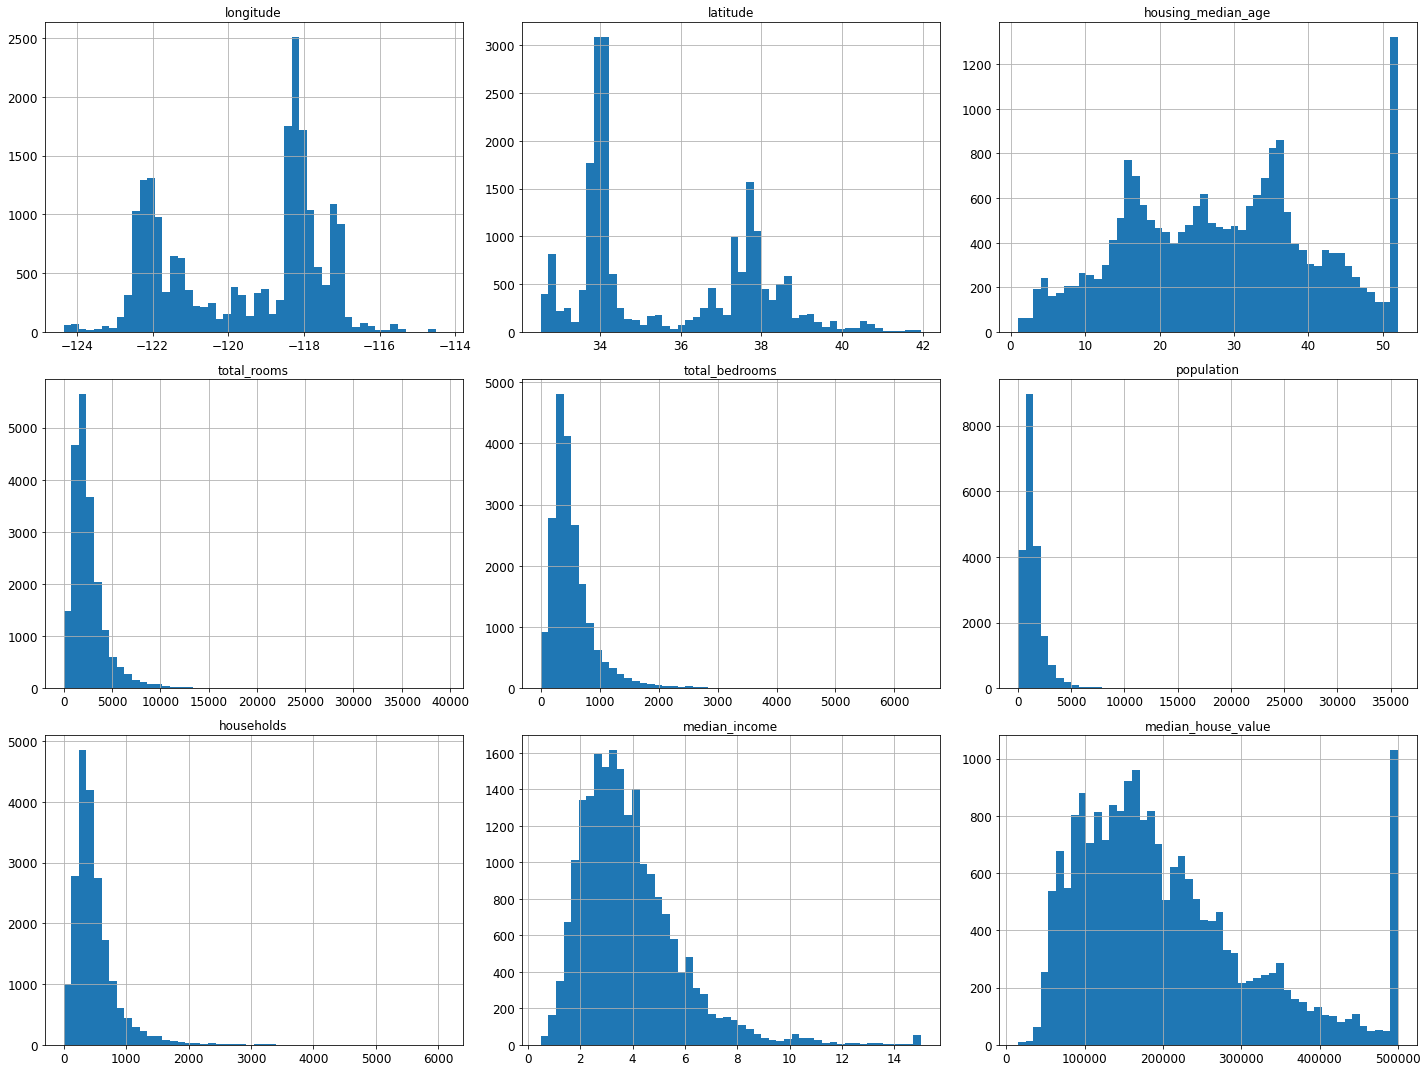

In [10]:
%matplotlib inline  # 주피터 노트북의 매직 명령
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: green"><strong>NOTE_</strong></span>hist() 메서드는 맷플롯립을 사용하고 결국 화면에 그래프를 그리기 위해 사용자 컴퓨터의 그래픽 백엔드를 필요로 한다. 그래서 그래프를 그리기 전에 맷플롯립이 사용할 백엔드를 지정해줘야 한다. 주피터의 매직 명령 %matplotlib inline을 사용하면 편리하다. 이 명령은 맷플롯립이 주피터 자체의 백엔드를 사용하도록 설정한다. 그러면 그래프는 노트북 안에 그려지게 된다. 주피터 노트북에서 그래프를 그릴 때 show() 메서드를 호출하는 것은 선택 사항이다. 주피터는 셀이 실행될 때 자동으로 그래프를 그려준다.
</div>

이 히스토그램에서 몇 가지 사항을 확인할 수 있다.

<ol>
    <li>먼저 중간 소득<sup>median income</sup> 특성이 US 달러로 표현되어 있지 않은 것 같다. 데이터를 취합한 팀에 확인해보니 스케일을 조정하고, 상한이 15(실제로는 15.0001), 하한이 0.5(실제로는 0.4999)가 되도록 만들었다고 한다. 대략 수만 달러를 나타낸다(예를 들어 3은 실제로 약 30,000달러를 의미한다). 머신러닝에서는 전처리된 데이터를 다루는 경우가 흔하고 이것이 문제가 되지는 않지만 데이터가 어떻게 계산된 것인지 반드시 이해하고 있어야 한다.<br><br></li>
    <li> 중간 주택 연도<sup>housing median age</sup>와 중간 주택 가격<sup>median housing value</sup> 역시 최댓값과 최솟값을 한정했다.<sup><a href='#p07' id="a07">7</a></sup> 중간 주택 가격의 경우는 속성(레이블)으로 사용되기 때문에 심각한 문제가 될 수 있다. 가격이 한곗값을 넘어가지 않도록 머신러닝 알고리즘이 학습될지도 모른다. 이것이 문제가 될지 안 될지는 클라이언트 팀(이 시스템의 출력을 사용할 팀)과 함께 검토하는 것이 좋다. 만약 그 팀에서 ＄500,000를 넘어가더라도 정확한 예측값이 필요하다고 한다면 우리가 선택할 수 있는 방법은 두 가지이다.<br><br>
    <ol>
        <li> 한곗값 밖의 구역에 대한 정확한 레이블을 구한다.</li>
        <li> 훈련 세트에서 이런 구역을 제거한다(＄500,000가 넘는 값에 대한 예측은 평가 결과가 매우 나쁠 것이므로 테스트 세트에서도 제거한다).</li><br>
        </ol>
    <li> 특성들의 스케일이 서로 많이 다르다. 특성 스케일링에 대해서는 이 장의 뒷부분에서 살펴보겠다.<br><br></li>
    <li> 마지막으로 많은 히스토그램의 꼬리가 두껍다. 가운데에서 왼쪽보다 오른쪽으로 더 멀리 뻗어 있다. 이런 형태는 일부 머신러닝 알고리즘에서 패턴을 찾기 어렵게 만든다. 나중에 이런 특성들을 좀 더 종 모양의 분포가 되도록 변형시키겠다.</li>
    </ol>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span>데이터를 더 깊게 들여다보기 전에 테스트 세트를 따로 떼어놓아야 한다. 그리고 테스트 세트를 절대 들여다보면 안 된다.</div>

## 테스트 세트 만들기

이 단계에서 데이터 일부를 자진해서 떼어놓으라는 것이 이상하게 들릴지 모르겠다. 지금까지는 데이터를 잠시 살펴봤을 뿐이고 어떤 알고리즘을 사용할지 정하기 전에 전체 데이터를 자세히 파악해야 하지 않을까? 사실 맞다. 하지만 우리 뇌는 매우 과대적합되기 쉬운 엄청난 패턴 감지 시스템이다. 만약 테스트 세트를 들여다본다면 테스트 세트에서 겉으로 드러난 어떤 패턴에 속아 특정 머신러닝 모델을 선택하게 될지도 모른다. 이 테스트 세트로 일반화 오차를 추정하면 매우 낙관적인 추정이 되며 시스템을 론칭했을 때 기대한 성능이 나오지 않을 것이다. 이를 <strong>데이터 스누핑</strong><sup>data snooping</sup> 편향이라고 한다.

테스트 세트를 생성하는 일은 이론적으로 간단하다. 무작위로 어떤 샘플을 선택해서 데이터셋의 20% 정도를(또는 데이터셋이 매우 크다면 그보다 적게) 떼어놓으면 된다.

In [11]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

In [12]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

이 함수를 다음과 같이 사용할 수 있다.

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [14]:
len(test_set)

4128

이것도 괜찮지만 완벽하지는 않다. 프로그램을 다시 실행하면 다른 테스트 세트가 생성된다! 여러 번 계속하면 우리는(또는 우리 머신러닝 알고리즘이) 전체 데이서셋을 보는 셈이므로 이런 상황은 피해야 한다.

한 가지 해결책은 처음 실행에서 테스트 세트를 저장하고 다음번 실행에서 이를 불러들이는 것이다. 또 다른 방법은 항상 같은 난수 인덱스가 생성되도록 <code>np.random.permutation()</code>을 호출하기 전에 난수 발생기의 초깃값을 지정하는 것이다(예를 들면 <code>np.random.seed(42)</code><sup id="a08">[8](#p08)</sup>).

하지만 이 두 해법 모두 다음번에 업데이트된 데이터셋을 사용하려면 문제가 된다. 데이터셋을 업데이트한 후에도 안정적인 훈련/테스트 분할을 위한 일반적인 해결책은 샘플의 식별자를 사용하여 테스트 세트로 보낼지 말지 정하는 것이다(샘플이 고유하고 변경 불가능한 식별자를 가지고 있다고 가정한다). 예를 들어 각 샘플마다 식별자의 해시값을 계산하여 해시 최댓값의 20%보다 작거나 같은 샘플만 테스트 세트로 보낼 수 있다. 이렇게 하면 여러 번 반복 실행되면서 데이터셋이 갱신되더라도 테스트 세트가 동일하게 유지된다. 새로운 테스트 세트는 새 샘플의 20%를 갖게 되지만 이전에 훈련 세트에 있던 샘플은 포함시키지 않을 것이다.

다음은 이를 구현한 코드이다.

In [22]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

안타깝게도 주택 데이터셋에는 식별자 칼럼이 없다. 대신 행의 인덱스를 ID로 사용하면 간단히 해결된다.

In [23]:
housing_with_id = housing.reset_index() # 'index' 열이 추가된 데이터프레임을 반환
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

행의 인덱스를 고유 식별자로 사용할 때 새 데이터는 데이터셋의 끝에 추가되어야 하고 어떤 행도 삭제되지 않아야 한다. 이것이 불가능할 땐 고유 식별자를 만드는 데 안전한 특성을 사용해야 한다. 예를 들어 구역의 위도와 경도는 몇백 년 후까지 안정적이라고 보장할 수 있으므로 두 값을 연결하여 다음과 같이 ID를 만들 수 있다.<sup id="a09">[9](#p09)</sup>

In [24]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [25]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


사이킷런은 데이터셋을 여러 서브셋으로 나누는 다양한 방법을 제공한다. 가장 간단한 함수는 <code>train_test_split()</code>으로, split_train_test와 아주 비슷하지만 두 가지 특징이 더 있다. 첫째, 앞서 설명한 난수 초깃값을 지정할 수 있는 random_state 매개변수가 있고, 둘째, 행의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있다(이는 예를 들어 데이터프레임이 레이블에 따라 여러 개로 나뉘어 있을 때 매우 유용하다).<sup id="a10">[10](#p10)</sup>

In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [23]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND,2
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND,2
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY,3
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN,4
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN,3


지금까지는 순수한 무작위 샘플링 방식을 보았다. 데이터셋이 충분히 크다면(특히 특성 수에 비해) 일반적으로 괜찮지만, 그렇지 않다면 샘플링 편향이 생길 가능성이 크다. 설문조사 기관에서 1,000명에게 질문 몇 개를 하려 할 때 그냥 전화번호부에서 1,000명을 무작위로 뽑는 것이 아니다. 전체 인구를 대표할 수 있는 1,000명을 선택하기 위해 노력한다. 미국 인구의 51.3%가 여성이고 48.7%가 남성이라면, 잘 구성된 설문조사는 샘플에서도 이 비율을 유지해야 한다. 즉, 여성은 513명, 남성은 487명이어야 한다. 이를 <strong>계층적 샘플링</strong><sup>stratified sampling</sup>이라고 한다. 전체 인구는 <strong>계층</strong><sup>strata</sup>이라는 동질의 그룹으로 나뉘고, 테스트 세트가 전체 인구를 대표하도록 각 계층에서 올바른 수의 샘플을 추출한다. 완전한 무작위 샘플링을 사용하여 설문을 진행하면 49%보다 적거나 54%보다 많은 여성이 테스트 세트에 들어갈 확률이 약 12%이다.<sup id="a11">[11](#p11)</sup> 어느 방법을 사용하든 설문조사 결과를 크게 편향시키게 된다.

전문가가 중간 소득이 중간 주택 가격을 예측하는 데 매우 중요하다고 이야기해주었다고 가정하자. 이 경우 테스트 세트가 전체 데이터셋에 있는 여러 소득 카테고리를 잘 대표해야 한다. 중간 소득이 연속적인 숫자형 특성이므로 소득에 대한 카테고리 특성을 만들어야 한다. 중간 소득의 히스토그램을 조금 더 자세히 살펴보자. 

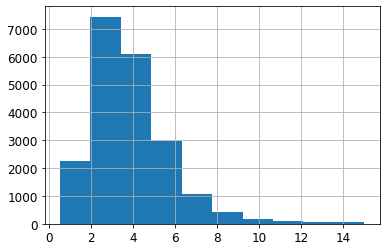

In [24]:
housing["median_income"].hist();

중간 소득 대부분은 1.5에서 6(즉 ＄15,000 ~ ＄60,000) 사이에 모여 있지만 일부는 ＄60,000를 넘기도 한다. 계층별로 데이터셋에 충분한 샘플 수가 있어야 한다. 그렇지 않으면 계층의 중요도를 추정하는데 편향이 발생할 것이다. 이 말은 너무 많은 계층으로 나누면 안 된다는 뜻이고 각 계층이 충분히 커야 한다는 것이다. 다음 코드는 <code>pd.cut()</code> 함수를 사용해 카테고리 5개를 가진 소득 카테고리 특성을 만드는 것이다(1에서 5까지 레이블을 가진다). 카테고리 1은 0에서 1.5까지 범위(즉 ＄15,000 이하)이고 카테고리 2는 1.5에서 3까지 범위가 되는 식이다.

In [25]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [26]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

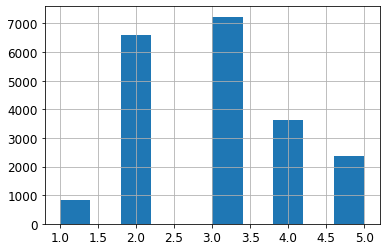

In [27]:
housing["income_cat"].hist();

이제 소득 카테고리를 기반으로 계층 샘플링을 할 준비가 되었다. 사이킷런의 <code>StratifiedShuffleSplit()</code>를 사용할 수 있다.<sup id="a12">[12](#p12)</sup>

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

의도대로 되었는지 살펴보자. 테스트 세트에서 소득 카테고리의 비율을 먼저 살펴보겠다.

In [29]:
strat_test_set["income_cat"].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

원본과 비슷한 비율의 계층을 가진 것을 확인할 수 있다.

In [30]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

비슷한 코드로 전체 데이터셋에 있는 소득 카테고리의 비율을 측정할 수 있다. 다음은 전체 데이터셋과 계층 샘플링으로 만든 테스트 세트에서 소득 카테고리 비율을 비교한 것이다. 그림에서 보듯이 계층 샘플링을 사용해 만든 테스트 세트가 전체 데이터셋에 있는 소득 카테고리의 비율과 거의 같다. 반면, 일반 무작위 샘플링으로 만든 테스트 세트는 비율이 많이 달라졌다.

In [31]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts(normalize=True)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [32]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


이제 income_cat 특성을 삭제해서 데이터를 원래 상태로 되돌리겠다.

In [33]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

테스트 세트 생성에 대해 자세히 설명하는 데에는 그럴 만한 이유가 있다. 종종 등한시되기도 하지만 머신러닝 프로젝트에서 아주 중요한 부분이기 때문이다. 게다가 이런 아이디어들은 나중에 교차 검증에 대해 이야기할 때 도움이 된다. 이제 데이터를 탐색하는 다음 단계로 넘어가자.

# 데이터 이해를 위한 탐색과 시각화

지금까지는 다뤄야 할 데이터의 종류를 파악하기 위해 데이터를 간단히 살펴보았다. 이제 조금 더 깊이 파악해보도록 하겠다.

먼저 테스트 세트를 떼어놓았는지 확인하고 훈련 세트에 대해서만 탐색을 하겠다. 또한 훈련 세트가 매우 크면 조작을 간단하고 빠르게 하기 위해 탐색을 위한 세트를 별도로 샘플링할 수도 있다. 예제에서는 크기가 작으므로 훈련 세트 전체를 사용한다. 훈련 세트를 손상시키지 않기 위해 복사본을 만들어 사용한다.

In [34]:
housing = strat_train_set.copy()

## 지리적 데이터 시각화

지리 정보(위도와 경도)가 있으니 모든 구역을 산점도로 만들어 데이터를 시각화하는 것은 좋은 생각이다.

그림 저장: bad_visualization_plot


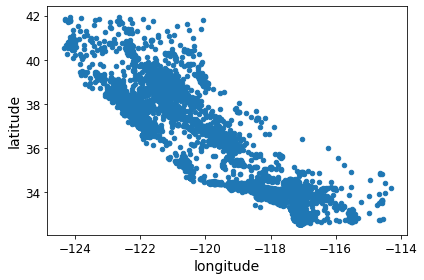

In [35]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

이 그림은 캘리포니아 지역을 잘 나타내지만 어떤 특별한 패턴을 찾기는 힘들다. alpha 옵션을 0.1로 주면 데이터 포인트가 밀집된 영역을 잘 보여준다.

그림 저장: better_visualization_plot


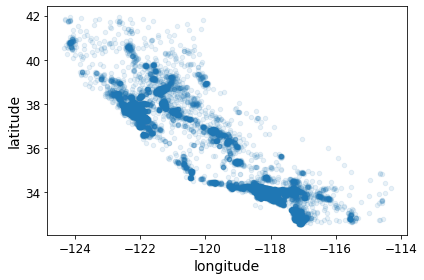

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

확실히 베이 에어리어<sup>Bay Area</sup>와 로스앤젤레스<sup>Los Angeles</sup> 근처, 샌디에고<sup>San Diego</sup> 같이 밀집된 지역이 눈에 잘 띄고, 센트럴 밸리<sup>Central Valley</sup> 특히 새크라멘토<sup>Sacramento</sup>와 프레즈노<sup>Fresno</sup> 근처를 따라 밀집된 지역이 긴 띠를 이루고 있다.<sup id="a13">[13](#p13)</sup>

우리 뇌는 그림에서 패턴을 잘 인식해내지만 더 두드러진 패턴을 보려면 매개변수를 다양하게 조절해봐야 한다.

이제 주택 가격을 나타내보겠다. 원의 반지름은 구역의 인구를 나타내고(매개변수 s), 색상은 가격을 나타낸다(매개변수 c). 여기서는 미리 정의된 컬러 맵<sup>color map</sup> 중 파란색(낮은 가격)에서 빨간색(높은 가격)까지 범위를 가지는 jet을 사용한다(매개변수 cmap).

그림 저장: housing_prices_scatterplot


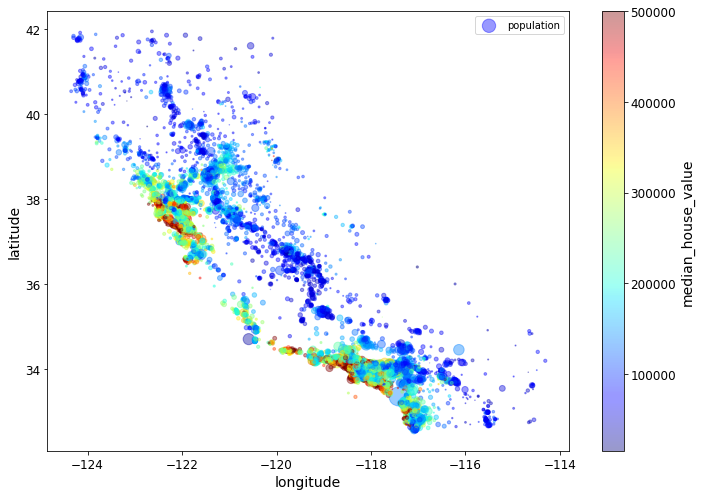

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [38]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x1d53d4d8cd0>)

그림 저장: california_housing_prices_plot


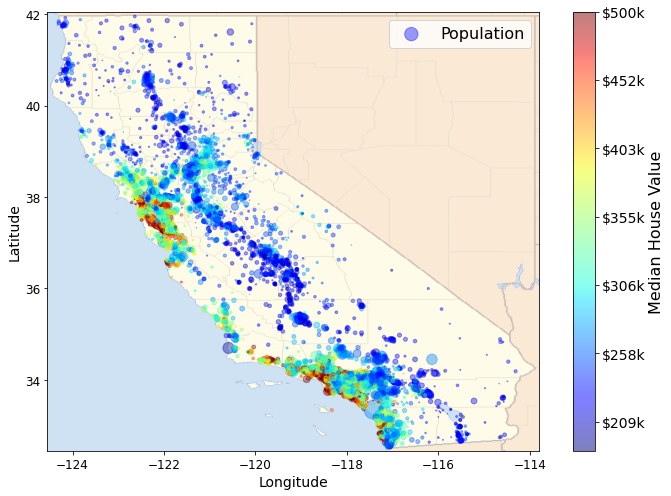

In [39]:
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing["population"]/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

아마 예상했겠지만 이 그림에서 주택 가격은 지역(예를 들면 바다와 인접한 곳)과 인구 밀도에 관련이 매우 크다는 사실을 알 수 있다. 군집 알고리즘<sup>clustering algorithm</sup>을 사용해 주요 군집을 찾고 군집의 중심까지의 거리를 재는 특성을 추가할 수 있다. 해안 근접성 특성이 유용할 수 있지만, 북부 캘리포니아 지역의 해안가는 주택 가격이 그리 높지 않아 간단한 규칙이 적용되기 어렵다.<sup id="a14">[14](#p14)</sup>

## 상관관계 조사

데이터셋이 너무 크지 않으므로 모든 특성 간의 <strong>표준 상관계수</strong><sup>standard correlation coefficient</sup> (<strong>피어슨</strong><sup>Pearson</sup>의 <i><strong>r</strong></i> 이라고도 부른다)를 <code>corr()</code> 메서드를 이용해 쉽게 계산할 수 있다.

In [40]:
corr_matrix = housing.corr()

중간 주택 가격과 다른 특성 사이의 상관관계 크기가 얼마나 되는지 살펴보겠다.

In [41]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

상관관계의 범위는 -1부터 1까지이다. 1에 가까우면 강한 양의 상관관계를 가진다는 뜻이다. 예를 들어 중간 주택 가격(median_house_value)은 중간 소득(median_income)이 올라갈 때 증가하는 경향이 있다. 계수가 -1에 가까우면 강한 음의 상관관계를 나타낸다. 위도<sup>latitude</sup>와 중간 주택 사이에는 약한 음의 상관관계가 보인다(즉, 북쪽으로 갈수록 주택 가격이 조금씩 내려가는 경향이 있다). 마지막으로 계수가 0에 가까우면 선형적인 상관관계가 없다는 뜻이다. 다음은 가로축과 세로축 사이의 여러 가지 상관관계를 그래프로 보여준다.

<img src='./images/end_to_end_project/scc.png'>
<div style="text-align: center"><strong>피어슨의 상관 계수</strong>(출처: 위키백과 - 퍼블릭 도메인 이미지)</div>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span>상관계수는 선형적인 상관관계만 측정한다(<i>x</i>가 증가하면 <i>y</i>는 증가하거나 감소한다). 그래서 비선형적인 관계는 잡을 수 없다(예를 들어 <i>x</i>가 0에 가까워지면 <i>y</i>가 증가하는 경우). 위의 마지막 줄에 있는 그래프들은 두 축이 완전히 독립적이지 않음에도 상관계수가 0이다. 즉, 비선형 관계의 예이다. 두 번째 줄은 상관계수가 1이거나 -1인 경우이다. 상관계수는 기울기와 상관없다. 예를 들어 인치<sup>inch</sup>단위의 키는 피트<sup>feet</sup>나 나노미터<sup>nanometer</sup>단위의 키와 상관계수가 1이다.</div>

특정 사이의 상관관계를 확인하는 다른 방법은 숫자형 특성 사이에 산점도를 그려주는 판다스의 <code>scatter_matrix()</code> 함수를 사용하는 것이다. 여기서는 숫자형 특성이 11개이므로 총 11<sup>2</sup> = 121개의 그래프가 되어 한 페이지에 모두 나타낼 수 없으므로, 중간 주택 가격과 상관관계가 높아 보이는 특성 몇 개만 살펴보겠다.

그림 저장: scatter_matrix_plot


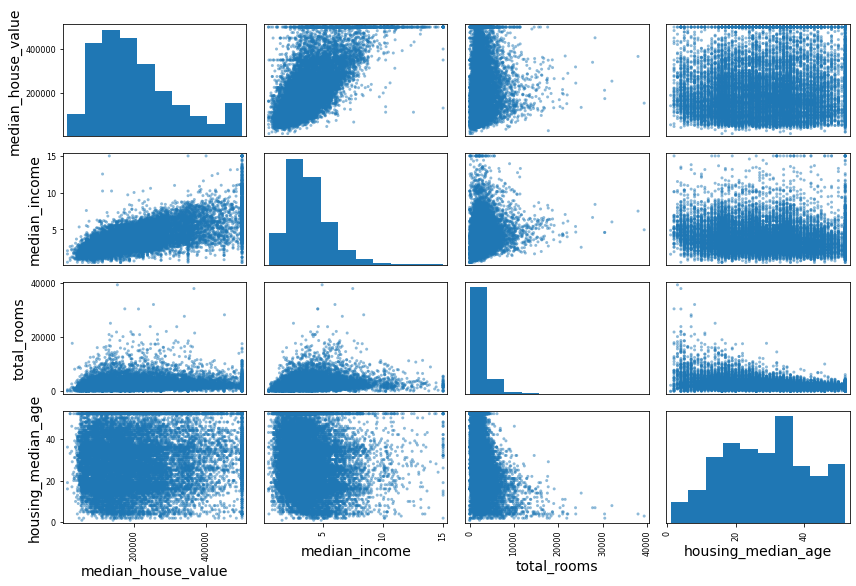

In [42]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

대각선 방향(왼쪽 위에서 오른쪽 아래로)은 각 변수 자신에 대한 것이라 그냥 직선이 되므로 유용하지 않다. 그래서 판다스는 이곳에 각 특성의 히스토그램을 그린다(다른 옵션도 가능하다. 자세한 내용은 판다스 문서를 참고하자<sup id="a15">[15](#p15)</sup>).

중간 주택 가격(median_house_value)을 예측하는 데 가장 유용할 것 같은 특성은 중간 소득(median_income)이므로 상관관계 산점도를 확대해보겠다.

그림 저장: income_vs_house_value_scatterplot


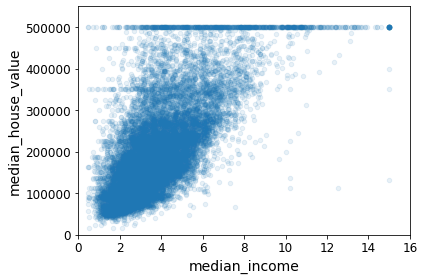

In [47]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

이 그래프는 몇 가지 사실을 보여준다. 첫째, 상관관계가 매우 강하다. 위쪽으로 향하는 경향을 볼 수 있으며 포인트들이 너무 널리 퍼져 있지 않다. 둘째, 앞서 본 가격 제한값이 ＄500,000에서 수평선으로 잘 보인다. 하지만 이 그래프에서 직선에 가까운 형태를 더 볼 수 있다. ＄450,000 근처에 수평선이 보이고 ＄350,000와 ＄280,000에도 있고 그 아래 조금 더 보인다. 알고리즘이 데이터에서 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋다.

상관에 관련된 <strong>공선성</strong>에 대해서도 고려하지 않으면 안 된다. 공선성은 변수(항목) 상호 간에 강하게 상관해 발생하는 문제이다.

공선성이 일으키는 문제에는 모델 작성에 관련된 계산량의 증대, 모델의 성능 저하, 모델의 불안정화 등이 있다. 이와 같은 문제를 방지하려면 데이터 준비 단계에서 상관이 강한 변수를 제외하면 된다.

## 특성 조합으로 실험

앞 절에서 데이터를 탐색하고 통찰을 얻는 여러 방법에 대한 아이디어를 얻었길 바란다. 머신러닝 알고리즘에 주입하기 전에 정제해야 할 조금 이상한 데이터를 확인했고, 특성 사이(특히 타깃 속성과의 사이)에서 흥미로운 상관관계를 발견했다. 어떤 특성은 꼬리가 두꺼운 분포라서 데이터를 변형해야 할 것이다(예를 들면 로그 스케일로). 물론 프로젝트마다 처한 상황은 다르겠지만 일반적인 아이디어는 비슷하다.

머신러닝 알고리즘용 데이터를 준비하기 전에 마지막으로 해볼 수 있는 것은 여러 특성의 조합을 시도해보는 것이다. 예를 들어 특정 구역의 방 개수는 얼마나 많은 가구 수가 있는지 모른다면 그다지 유용하지 않다. 진짜 필요한 것은 가구당 방 개수이다. 비슷하게 전체 침실 개수도 그 자체로는 유용하지 않다. 즉, 방 개수와 비교하는 게 낫다. 가구당 인원도 흥미로운 특성 조합일 것 같다. 이런 특성들을 만들어보자.

In [43]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

상관관계 행렬을 다시 확인해보자.

In [44]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

새로운 bedrooms_per_room 특성은 전체 방 개수나 침실 개수보다 중간 주택 가격과의 상관관계가 훨씬 높다. 확실히 침실/방의 비율이 낮은 집은 더 비싼 경향이 있다. 가구당 방 개수도 구역 내 전체 방 개수보다 더 유용하다. 당연히 더 큰 집이 더 비싸다.

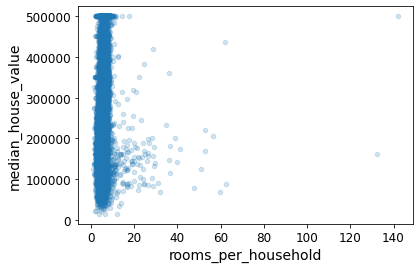

In [45]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.show()

이 탐색 단계는 완벽하지 않다. 시작을 잘해서 빨리 통찰을 얻는 것이 처음 프로토타입을 잘 만드는 데 도움이 될 것이다. 하지만 이는 반복적인 과정이다. 프로토타입을 만들고 실행한 후 그 결과를 분석해서 더 많은 통찰을 얻고 다시 이 탐색 단계로 돌아오게 된다.<sup id="a16">[16](#p16)</sup>

# 머신러닝 알고리즘을 위한 데이터 준비

이제 머신러닝 알고리즘을 위해 데이터를 준비할 차례이다. 이 작업을 수동으로 하는 대신 함수를 만들어 자동화해야 하는 이유가 있다.

<ul>
    <li>어떤 데이터셋에 대해서도 데이터 변환을 손쉽게 반복할 수 있다(예를 들어 다음번에 새로운 데이터셋을 사용할 때).</li><br>
    <li>향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.</li><br>
    <li>실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는 데 이 함수를 사용할 수 있다.</li><br>
    <li>여러 가지 데이터 변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하는 데 편리하다.</li>
    </ul>

하지만 먼저 원래 훈련 세트로 복원하고(strat_train_set을 다시 한번 복사한다), 예측 변수와 타깃값에 같은 변형을 적용하지 않기 위해 예측 변수와 레이블을 분리하겠다(<code>drop()</code>은 데이터 복사본을 만들며 strat_train_set에는 영향을 주지 않는다).

In [46]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## 데이터 정제

대부분의 머신러닝 알고리즘은 누락된 특성을 다루지 못하므로 이를 처리할 수 있는 함수를 몇 개 만들겠다. 앞서 total_bedrooms 특성에 값이 없는 경우를 보았는데 이를 고쳐보자. 방법은 세 가지이다.

<ul>
    <li>해당 구역을 제거한다.</li><br>
    <li>전체 특성을 삭제한다.</li><br>
    <li>어떤 값으로 채운다(0, 평균, 중간값 등).</li><br>
</ul>

위에서 언급한 세 가지 방법을 설명하기 위해 주택 데이터셋의 복사본을 만든다. 이때 적어도 하나의 열이 비어있는 행만 고른다. 이렇게 하면 각 옵션의 정확한 동작을 눈으로 쉽게 확인할 수 있다.

In [48]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


첫 번째, 해당 구역을 제거한다.

In [49]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


두 번째, 전체 특성을 삭제한다.

In [50]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


세 번째, 어떤 값으로 채운다(여기선 중간값으로 채운다). 이 방법을 선택하면 훈련 세트에서 중간값을 계산하고 누락된 값을 이 값으로 채워 넣어야 한다. 계산한 중간값을 저장하는 것을 잊지 말자.  나중에 시스템을 평가할 때 테스트 세트에 있는 누락된 값과 시스템이 실제 운영될 때 새로운 데이터에 있는 누락된 값을 채워넣는데 필요하기 때문이다.<sup id="a17">[17](#p17)</sup>

In [51]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

In [52]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


사이킷런의 <code>SimpleImputer</code>는 누락된 값을 손쉽게 다루도록 해준다. 어떻게 사용하는지 살펴보자. 먼저 누락된 값을 특성의 중간값으로 대체한다고 지정하여 SimpleImputer의 객체를 생성한다.

In [53]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중간값이 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성인 ocean_proximity를 제외한 데이터 복사본을 생성한다.

In [54]:
housing_num = housing.drop("ocean_proximity", axis=1)

다른 방법으로는 dtype을 이용해 수치형 특성만을 추출할 수 있다.

In [55]:
housing_num = housing.select_dtypes(include=[np.number])

이제 imputer 객체의 <code>fit()</code> 메서드를 사용해 훈련 데이터에 적용할 수 있다.

In [56]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

imputer는 각 특성의 중간값을 계산해서 그 결과를 객체의 statistics_ 속성에 저장한다. total_bedrooms 특성에만 누락된 값이 있지만 나중에 시스템이 서비스될 때 새로운 데이터에서 어떤 값이 누락될지 확신할 수 없으므로 모든 수치형 특성에 imputer를 적용하는 것이 바람직하다.

In [57]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

이제 학습된 imputer 객체를 사용해 훈련 세트에서 누락된 값을 학습한 중간값으로 바꿀 수 있다.

In [58]:
X = imputer.transform(housing_num)

이 결과는 변형된 특성들이 들어 있는 평범한 넘파이 배열이다. 이를 다시 판다스 데이터프레임으로 간단히 되돌릴 수 있다.

In [59]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

누락값이 중간값으로 채워진 모습을 볼 수 있다.

In [60]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


imputer 객체의 strategy 속성에는 해당 imputer의 보간 방법이 저장되어 있다.

In [61]:
imputer.strategy

'median'

그리고 누락값이 중간값으로 채워진 데이터프레임은 다음과 같다.

In [62]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


<div style="border:1px solid; padding:10px;">
    <div style="text-align: center"><strong>사이킷런의 설계 철학</strong></div><br>
    사이킷런의 API는 아주 잘 설계되어 있다. 주요 설계 원칙은 다음과 같다.<sup id="a18"><a href='#p18'>18</a></sup>
    <ul>
        <li><strong>일관성</strong>: 모든 객체가 일관되고 단순한 인터페이스를 공유한다.</li><br>
            <ul>
                <li><strong>추정기</strong><sup>estimator</sup>: 데이터셋을 기반으로 일련의 모델 파라미터들을 추정하는 객체를 추정기라고 한다(예를 들어 imputer 객체는 추정기이다). 추정 자체는 <code>fit()</code> 메서드에 의해 수행되고 하나의 매개변수로 하나의 데이터셋만 전달한다(지도 학습 알고리즘에서는 매개변수가 두 개로, 두 번째 데이터셋은 레이블을 담고 있다). 추정 과정에서 필요한 다른 매개변수들은 모두 하이퍼파라미터로 간주되고(예를 들면 imputer 객체의 strategy 매개변수), 인스턴스 변수<sup id="a19"><a href="#p19">19</a></sup>로 저장된다(보통 생성자의 매개변수로 전달한다).<sup id="a20"><a href='#p20'>20</a></sup></li><br>
                <li><strong>변환기</strong><sup>transformer</sup>: (imputer 같이) 데이터셋을 변환하는 추정기를 변환기라고 한다. 여기서도 API는 매우 단순하다. 변환은 데이터셋을 매개변수로 전달받은 <code>transform()</code> 메서드가 수행한다. 그리고 변환된 데이터셋을 반환한다. 이런 변환은 일반적으로 imputer의 경우와 같이 학습된 모델 파라미터에 의해 결정된다.<sup id="a21"><a href="#p21">21</a></sup> 모든 변환기는 <code>fit()</code>와 <code>transform()</code>을 연달아 호출하는 것과 동일한 <code>fit_transform()</code>메서드도 가지고 있다(이따금 <code>fit_transform()</code>이 최적화되어 있어서 더 빠르다).</li><br>
                <li><strong>예측기</strong><sup>predictor</sup>: 일부 추정기는 주어진 데이터셋에 대해 예측을 만들 수 있다. 예를 들어 앞 장에 나온 LinearRegression 모델이 예측기이다. 어떤 나라의 1인당 GDP가 주어질 때 삶의 만족도를 예측했다. 예측기의 <code>predict()</code> 메서드는 새로운 데이터셋을 받아 이에 상응하는 예측값을 반환한다. 또한 테스트 세트(지도 학습 알고리즘이라면 레이블도 함께)를 사용해 예측의 품질을 측정하는 <code>score()</code> 메서드를 가진다.<sup id="a22"><a href="#p22">22</a></sup></li>
            </ul>
        <li><strong>검사 기능</strong>: 모든 추정기의 하이퍼파라미터는 공개<sup>public</sup> 인스턴스 변수로 직접 접근할 수 있고(예를 들면 imputer.strategy), 모든 추정기의 학습된 모델 파라미터도 접미사로 밑줄을 붙여서 공개 인스턴스 변수로 제공된다(예를 들면 imputer.statistics_).<sup id="a23"><a href="#p23">23</a></sup></li><br>
        <li><strong>클래스 남용 방지</strong>: 데이터셋을 별도의 클래스가 아니라 넘파이 배열이나 사이파이 희소<sup>sparse</sup> 행렬로 표현한다. 하이퍼파라미터는 보통의 파이썬 문자열이나 숫자이다.</li><br>
        <li><strong>조합성</strong>: 기존의 구성요소를 최대한 재사용한다. 앞으로 보겠지만 예를 들어 여러 변환기를 연결한 다음 마지막에 추정기 하나를 배치한 Pipeline 추정기를 쉽게 만들 수 있다.</li><br>
        <li><strong>합리적인 기본값</strong>: 사이킷런은 일단 돌아가는 기본 시스템을 빠르게 만들 수 있도록 대부분의 매개변수에 합리적인 기본값을 지정해두었다.</li>
    </ul>
</div>

## 텍스트와 범주형 특성 다루기

지금까지 수치형 특성만 다루었다. 이제 텍스트 특성을 살펴보자. 이 데이터셋에는 ocean_proximity 하나뿐이다. 처음 10개 샘플에서 이 특성값을 확인해보자.

In [63]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


이는 임의의 텍스트가 아니다. 가능한 값을 제한된 개수로 나열한 것이고 각 값은 카테고리를 나타낸다. 따라서 이 특성은 범주형 특성이다. 대부분의 머신러닝 알고리즘은 숫자를 다루므로 이 카테고리를 텍스트에서 숫자로 변환하겠다. 이를 위해 사이킷런의 OrdinalEncoder 클래스를 사용한다.

In [64]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

categories_ 인스턴스 변수를 사용해 카테고리 목록을 얻을 수 있다. 범주형 특성마다 카테고리들의 1D 배열을 담은 리스트가 반환된다(이 경우는 범주형 특성이 하나만 있으므로 배열 하나를 담은 리스트가 반환된다).

In [65]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

이 표현 방식의 문제는 머신러닝 알고리즘이 가까이 있는 두 값이 떨어져 있는 두 값보다 더 비슷하다고 생각한다는 점이다. 일부 경우에는 괜찮다(예를 들어 'bad', 'average', 'good', 'excellent'와 같은 순서가 있는 카테고리의 경우). 하지만 이는 ocean_proximity 열에 해당되지 않는다(예를 들어 카테고리 0과 1보다 카테고리 0과 4가 확실히 더 비슷하다). 이 문제는 일반적으로 카테고리별 이진 특성을 만들어 해결한다. 카테고리가'<1H OCEAN'일 때 한 특성이 1이고(그 외 특성은 0), 카테고리가 'INLAND'일 때 다른 한 특성이 1이 되는(역시 그 외에는 0) 식이다. 한 특성만 1이고(핫) 나머지는 0이므로 이를 <strong>원-핫 인코딩</strong><sup>one-hot encoding</sup>이라고 부른다. 이따금 새로운 특성을 <strong>더미</strong><sup>dummy</sup> 특성이라고도 부른다. 사이킷런은 범주의 값을 원-핫 벡터로 바꾸기 위한 OneHotEncoder 클래스를 제공한다.

In [66]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

출력을 보면 넘파이 배열이 아니고 사이파이<sup>SciPy</sup><strong>희소 행렬</strong><sup>sparse matrix</sup>이다. 이는 수천 개의 카테고리가 있는 범주형 특성일 경우 매우 효율적이다. 이런 특성을 원-핫 인코딩하면 열이 수천 개인 행렬로 변하고 각 행은 1이 하나뿐이고 그 외에는 모두 0으로 채워져 있을 것이다. 0을 모두 메모리에 저장하는 것은 낭비이므로 희소 행렬은 0이 아닌 원소의 위치만 저장한다. 이 행렬을 거의 일반적인 2차원 배열처럼 사용할 수 있지만<sup id="a24">[24](#p24)</sup> (밀집된) 넘파이 배열로 바꾸려면 <code>toarray()</code> 메서드를 호출하면 된다.

In [67]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

또는 OneHotEncoder를 만들 때 sparse=False로 지정할 수 있다.

In [68]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

여기에서도 인코더의 categories_ 인스턴스 변수를 사용해 카테고리 리스트를 얻을 수 있다.

In [69]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

<strong>TIP</strong> 카테고리 특성이 담을 수 있는 카테고리 수가 많다면(예를 들면 국가 코드, 직업, 생물 종류 등) 원-핫 인코딩은 많은 수의 입력 특성을 만든다. 이는 훈련을 느리게 하고 성능을 감소시킬 수 있다. 이런 현상이 나타나면 범주형 입력값을 이 특성과 관련된 숫자형 특성으로 바꾸고 싶을 것이다. 예를 들어 ocean_proximity 특성을 해안까지 거리로 바꿀 수 있다(비슷하게 국가 코드는 국가의 인구와 1인당 GDP로 바꿀 수 있다). 또는 각 카테고리를 <strong>임베딩</strong><sup>embedding</sup>이라고 부르는 학습 가능한 저차원 벡터로 바꿀 수 있다. 훈련하는 동안 각 카테고리의 표현이 학습된다. 이는 <strong>표현 학습</strong><sup>representation learning</sup>의 한 예이다.

## 나만의 변환기

사이킷런이 유용한 변환기를 많이 제공하지만 특별한 정제 작업이나 어떤 특성들을 조합하는 등의 작업을 위해 자신만의 변환기를 만들어야 할 때가 있다. 내가 만든 변환기를 (파이프라인과 같은) 사이킷런의 기능과 매끄럽게 연동하고 싶을 것이다. 사이킷런은 (상속이 아닌) 덕 타이핑<sup>duck typing</sup><sup id="a25">[25](#p25)</a></sup>을 지원하므로 <code>fit()</code>(self를 반환), <code>transform()</code>, <code>fit_transform()</code> 메서드를 구현한 파이썬 클래스를 만들면 된다.

마지막 메서드는 TransformerMixin을 상속하면 자동으로 생성된다.<sup id="a26">[26](#p26)</sup> 또한 BaseEstimator를 상속하면(그리고 생성자에 \*args나 \*\*kargs를 사용하지 않으면) 하이퍼파라미터 튜닝에 필요한 두 메서드(<code>get_params()</code>와 <code>set_params()</code>)를 추가로 얻게 된다.<sup id="a27">[27](#p27)</sup>

예를 들어 다음은 앞서 이야기한 조합 특성을 추가하는 간단한 변환기이다.

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # 아무것도 하지 않음
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

housing_extra_attribs는 넘파이 배열이기 때문에 열 이름이 없다(안타깝지만 사이킷런을 사용할 때 생기는 문제이다). DataFrame으로 복원하려면 다음과 같이 할 수 있다.

In [71]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


이 경우에는 변환기가 add_bedrooms_per_room 하이퍼파라미터 하나를 가지며 기본값을 True로 지정한다(합리적인 기본값을 주는 것이 좋다). 이 특성을 추가하는 것이 머신러닝 알고리즘에 도움이 될지 안 될지 이 하이퍼파라미터로 쉽게 확인해볼 수 있다. 일반적으로 100% 확신이 없는 모든 데이터 준비 단계에 대해 하이퍼파라미터를 추가할 수 있다. 이런 데이터 준비 단계를 자동화할수록 더 많은 조합을 자동으로 시도해볼 수 있고 최상의 조합을 찾을 가능성을 매우 높여준다(그리고 시간도 많이 절약된다).

## 특성 스케일링

데이터에 적용할 가장 중요한 변환 중 하나가 <strong>특성 스케일링</strong><sup>feature scaling</sup>이다. 몇 가지를 빼고는,<sup id="a28">[28](#p28)</sup> 머신러닝 알고리즘은 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 않다. 주택 가격 데이터도 이에 해당한다. 즉, 전체 방 개수의 범위는 6에서 39,320인 반면 중간 소득의 범위는 0에서 15까지이다. 타깃값에 대한 스케일링은 일반적으로 불필요하다.

모든 특성의 범위를 같도록 만들어주는 방법으로 <strong>min-max 스케일링</strong>과 <strong>표준화</strong><sup>standardization</sup>가 널리 사용된다.

<img src='./images/formula/normalization.png'>

min-max 스케일링이 가장 간단하다(많은 사람이 이를 <strong>정규화</strong><sup>normalization</sup><sup id="a29">[29](#p29)</sup>라고 부른다). 0\~1 범위에 들도록 값을 이동하고 스케일을 조정하면 된다. 데이터에서 최솟값을 뺀 후 최댓값과 최솟값의 차이로 나누면 이렇게 할 수 있다. 사이킷런에는 이에 해당하는 MinMaxScaler 변환기를 제공한다. 0\~1 사이를 원하지 않는다면 feature_range 매개변수로 범위를 변경할 수 있다.

<img src='./images/formula/standardization.png'>

표준화는 다르다. 먼저 평균을 뺀 후(그래서 표준화를 하면 항상 평균이 0이 된다) 표준편차로 나누어 결과 분포의 분산이 1이 되도록 한다. 이렇게 가우시안 정규 분포를 가질 수 있도록 데이터를 변환하는 것은 몇몇 알고리즘에서 매우 중요하다. 특히 사이킷런에서 구현한 RBF 커널을 이용하는 서포트 벡터 머신이나 선형 회귀, 로지스틱 회귀는 데이터가 가우시안 분포를 가지고 있다고 가정하고 구현됐기 때문에 사전에 표준화를 적용하는 것은 예측 성능 향상에 중요한 요소가 될 수 있다. min-max 스케일링과는 달리 표준화는 범위의 상한과 하한이 없어 어떤 알고리즘에서는 문제가 될 수 있다(예를 들어 신경망은 종종 입력값의 범위로 0에서 1사이를 기대한다). 그러나 표준화는 이상치에 영향을 덜 받는다. 예를 들어 중간 소득을 (잘못해서) 100이라 입력한 구역을 가정해보자. min-max 스케일링은 0\~15 사이의 모든 다른 값을 0\~0.15로 만들어버리겠지만, 표준화는 크게 영향받지 않는다. 사이킷런에는 표준화를 위한 StandardSclaer 변환기가 있다.

<img src='./images/end_to_end_project/NormVsStand_box_plots-1.png'>

<div style="text-align: center"><strong>Norm VS Stand box plots</strong><br>출처: <a href='https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/' target='blank'>https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/</a></div>

<img src='./images/end_to_end_project/NormVsStand_diff.png'>

그렇다면 언제 정규화를 하고 언제 표준화를 할까? 이에 대한 명확한 답은 없다. 통상적으로는 <strong>표준화를 통해 이상치를 제거하고(68-95-99.7 참고), 그 다음 데이터를 정규화 해 상대적 크기에 대한 영향력을 줄인 다음 분석을 시작한다</strong>고 한다.<sup id="a30">[30](#p30)</sup>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span>모든 변환기에서 스케일링은 (테스트 세트가 포함된) 전체 데이터가 아니고 훈련 데이터에 대해서만 fit() 메서드를 적용해야 한다. 그런 다음 훈련 세트와 테스트 세트(그리고 새로운 데이터)에 대해 transform() 메서드를 사용한다.</div>

## 변환 파이프라인

앞서 보았듯이 변환 단계가 많으면 정확한 순서대로 실행되어야 한다. 다행히 사이킷런에는 연속된 변환을 순서대로 처리할 수 있도록 도와주는 Pipeline 클래스가 있다. 다음은 숫자 특성을 처리하는 간단한 파이프라인이다.

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipeline은 연속된 단계를 나타내는 이름/추정기 쌍의 튜플을 입력으로 받는다. 마지막 단계에는 변환기와 추정기를 모두 사용할 수 있고 그외에는 모두 변환기여야 한다(즉, <code>fit_transform()</code> 메서드를 가지고 있어야 한다<sup id="a31">[31](#p31)</sup>). 이름은 (고유하고 이중 밑줄 문자인 \_\_를 포함하지 않는다면) 무엇이든 상관없다. 나중에 하이퍼파라미터 튜닝할 때 필요할 것이다.

<img src='./images/end_to_end_project/pipeline_op.png'>

파이프라인의 <code>fit()</code> 메서드를 호출하면 모든 변환기의 <code>fit_transform()</code> 메서드를 순서대로 호출하면서<sup id="a32">[32](#p32)</sup> 한 단계의 출력을 다음 단계의 입력으로 전달한다. 마지막 단계에서는 <code>fit()</code> 메서드만 호출한다.

파이프라인 객체는 마지막 추정기와 동일한 메서드를 제공한다. 이 예에서는 마지막 추정기가 변환기 StandardScaler이므로 파이프라인이 데이터에 대해 모든 변환을 순서대로 적용하는 <code>transform()</code> 메서드를 가지고 있다(또한 앞에서 사용한 <code>fit_transform()</code> 메서드도 가지고 있다).

지금까지 범주형 열과 수치형 열을 각각 다루었다. 하나의 변환기로 각 열마다 적절한 변환을 적용하여 모든 열을 처리할 수 있다면 더 편리할 것이다. 사이킷런 0.20버전에서 이런 기능을 위해 ColumnTransformer가 추가되었다. 다행히도 이 클래스는 판다스 DataFrame과 잘 동작한다. 이 클래스를 사용해 주택 가격 데이터에 전체 변환을 적용해보겠다.

In [73]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [74]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [75]:
housing.shape, housing_prepared.shape

((16512, 9), (16512, 16))

먼저 ColumnTransformer 클래스를 임포트한다. 그다음 수치형 열 이름의 리스트와 범주형 열 이름의 리스트를 만든다. 그다음 ColumnTransformer 클래스 객체를 만든다. 이 생성자는 튜플의 리스트를 받는다. 각 튜플은 이름, 변환기, 변환기가 적용될 열 이름(또는 인덱스)의 리스트로 이루어진다. 이 예에서 수치형 열은 앞서 정의한 num_pipeline을 사용해 변환되고 범주형 열은 OneHotEncoder을 사용해 변환되어야 한다. 마지막으로 ColumnTransformer를 주택 데이터에 적용한다. 각 변환기를 적절한 열에 적용하고 그 결과를 두 번째 축을 따라 연결한다(변환기는 동일한 개수의 행을 반환해야 한다).

OneHotEncoder는 희소 행렬을 반환하지만 num_pipeline는 밀집 행렬을 반환한다. 희소 행렬과 밀집 행렬이 섞여 있을 때 ColumnTransformer는 최종 행렬의 밀집 정도를 추정한다(즉 0이 아닌 원소의 비율). 밀집도가 임곗값(기본적으로 sparse_threshold=0.3이다)보다 낮으면 희소 행렬을 반환한다. 이 예에서는 밀집 행렬이 반환된다. 이로써 전체 주택 데이터를 받아 각 열에 적절한 변환을 적용하는 전처리 파이프라인을 만들었다.

<strong>TIP</strong> 튜플에 변환기를 사용하는 대신 삭제하고 싶은 열이 있다면 "drop" 문자열로 지정하거나 변환을 적용하지 않을 열이 있다면 "passthrough"로 지정할 수 있다. 기본적으로 나머지 열은(즉 나열되지 않은 열) 삭제된다. 하지만 이런 열을 다르게 처리하고 싶다면 remainder 하이퍼파라미터에 어떤 변환기를 (또는 "passthrough"를) 지정할 수 있다.

# 모델 선택과 훈련

문제를 정의한 후 데이터를 읽어 들이고 탐색했다. 그리고 훈련 세트와 테스트 세트로 나누고 머신러닝 알고리즘에 주입할 데이터를 자동으로 정제하고 준비하기 위한 변환 파이프라인을 작성했다. 이제 머신러닝 모델을 선택하고 훈련시킬 준비가 되었다.

## 훈련 세트에서 훈련하고 평가하기

이전 단계의 작업 덕분에 생각보다 훨씬 간단해졌다. 먼저 앞 장에서 했던 것처럼 선형 회귀 모델을 훈련시켜보겠다.

In [76]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

완전히 작동하는 선형 회귀 모델을 만들었다. 훈련 세트에 있는 몇 개 샘플에 대해 적용해보겠다.

In [77]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels))

예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


아주 정확한 예측은 아니지만(예를 들어 첫 번째 예측은 40% 가까이 벗어났다) 작동은 한다. 사이킷런의 <code>mean_square_error()</code> 함수를 사용해 전체 훈련 세트에 대한 이 회귀 모델의 RMSE를 측정해보겠다.

In [79]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

없는 것보다는 낫지만 확실히 좋은 점수는 아니다. 대부분 구역의 중간 주택 가격은 ＄120,000에서 ＄265,000 사이다. 그러므로 예측 오차가 ＄68,628인 것은 매우 만족스럽지 못하다. 이는 모델이 훈련 데이터에 과소적합된 사례이다. 이런 상황은 특성들이 좋은 예측을 만들 만큼 충분한 정보를 제공하지 못했거나 모델이 충분히 강력하지 못하다는 사실을 말해준다. 앞 장에서 보았듯이 과소적합을 해결하는 주요 방법은 더 강력한 모델을 선택하거나 훈련 알고리즘에 더 좋은 특성을 주입하거나 모델의 규제를 감소시키는 것이다. 이 모델은 규제를 사용하지 않았으므로 마지막 옵션을 제외된다. 특성을 더 많이 추가할 수 있지만(예를 들면 로그 스케일된 인구), 먼저 더 복잡한 모델을 시도해서 어떻게 되는지 보겠다.

DecisionTreeRegressor를 훈련시켜보겠다. 이 모델은 강력하고 데이터에서 복잡한 비선형 관계를 찾을 수 있다. 다음 코드는 이전과 비슷하다.

In [80]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

모델을 훈련시켰으니 훈련 세트로 평가해보자.

In [81]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

오차가 전혀 없는 것을 확인할 수 있다. 그렇다고 이 모델이 진짜 완벽을 의미하는 것이 아닌, 모델이 데이터에 너무 심하게 과대적합된 것으로 보인다. 이를 어떻게 확신할 수 있을까? 앞서 이야기했듯이 여러분은 확신이 드는 모델이 론칭할 준비가 되기 전까지 테스트 세트는 사용하지 않으려 하므로 훈련 세트의 일부분으로 훈련을 하고 다른 일부분은 모델 검증에 사용해야 한다.

## 교차 검증을 사용한 평가

결정 트리 모델을 평가하는 방법을 생각해보자. 우선 <code>train_test_split()</code> 함수를 사용해 훈련 세트를 더 작은 훈련 세트와 검증 세트로 나누고, 더 작은 훈련 세트에서 모델을 훈련 시키고 검증 세트로 모델을 평가하는 방법이 있다. 조금 수고스럽지만 너무 어렵지 않으며 매우 잘 작동한다.

<img src='./images/end_to_end_project/10_fold_cv.png'>

훌륭한 대안으로 사이킷런의 <strong>k-겹 교차 검증</strong><sup>k-fold cross-validation</sup> 기능을 사용하는 방법도 있다. 다음 코드는 훈련 세트를 <strong>폴드</strong><sup>fold</sup>라 불리는 10개의 서브셋으로 무작위로 분할한다. 그런 다음 결정 트리 모델을 10번 훈련하고 평가하는데, 매번 다른 폴드를 선택해 평가에 사용하고 나머지 9개 폴드는 훈련에 사용한다. 10개의 평가 점수가 담긴 배열이 결과가 된다.

In [82]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span>사이킷런의 교차 검증 기능은 scoring 매개변수에 (낮을수록 좋은) 비용 함수가 아니라 (클수록 좋은) 효용 함수를 기대한다. 그래서 평균 제곱 오차(MSE)의 반댓값(즉, 음숫값)을 계산하는 neg_mean_squared_error 함수를 사용한다. 이런 이유로 앞선 코드에서 제곱근을 계산하기 전에 -scores로 부호를 바꿨다.<sup id="a33"><a href='#p33'>33</a></div>

결과를 살펴보자.

In [83]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())
    
display_scores(tree_rmse_scores)

점수: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
평균: 71629.89009727491
표준 편차: 2914.035468468928


결정 트리 결과가 이전만큼 좋아 보이지 않다. 실제로 선형 회귀 모델보다 나쁘다! 교차 검증으로 모델의 성능을 추정하는 것뿐만 아니라 이 추정이 얼마나 정확한지도(즉, 표준편차) 측정할 수 있다. 결정 트리 점수가 대략 평균 71,630에서 ±2,914 사이이다. 검증 세트를 하나만 사용했다면 이런 정보를 얻지 못했을 것이다. 하지만 모델을 여러 번 훈련시켜야 해서 비용이 비싸므로 교차 검증을 언제나 쓸 수 있는 것은 아니다.

비교를 위해 선형 회귀 모델의 점수를 계산해보자.

In [84]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준 편차: 2880.328209818069


확실히 결정 트리 모델이 과대적합되어 선형 회귀 모델보다 성능이 더 나쁘다.

마지막으로 RandomForestRegressor 모델을 하나 더 시도해보자. 후에 보게 되겠지만 랜덤 포레스트는 특성을 무작위로 선택해서 많은 결정 트리를 만들고 그 예측을 평균 내는 방식으로 작동한다. 여러 다른 모델을 모아서 하나의 모델을 만드는 것을 <strong>앙상블 학습</strong>이라고 하며 머신러닝 알고리즘의 성능을 극대화하는 방법 중 하나이다.

In [85]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [86]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [87]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
평균: 50435.58092066179
표준 편차: 2203.3381412764606


훨씬 좋다. 랜덤 포레스트는 매우 훌륭해 보인다. 하지만 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 훨씬 낮으므로 이 모델도 여전히 훈련 세트에 과대적합되어 있다. 과대적합을 해결하는 방법은 모델을 간단히 하거나, 제한을 하거나(즉, 규제), 더 많은 훈련 데이터를 모으는 것이다. 랜덤 포레스트를 더 깊이 들어가기 전에, 여러 종류의 머신러닝 알고리즘으로 하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서 다양한 모델(다양한 커널의 서포트 벡터 머신, 신경망 등)을 시도해봐야 한다. 가능성 있는 2~5개 정도의 모델을 선정하는 것이 목적이다.

In [106]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

In [107]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, 
                             scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

점수: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
평균: 111814.1069260169
표준 편차: 2600.8402690892563


In [108]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor()
sgd_reg.fit(housing_prepared, housing_labels)
housing_predictions = sgd_reg.predict(housing_prepared)
sgd_mse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

79400.71300573736

In [110]:
sgd_scores = cross_val_score(sgd_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)
display_scores(sgd_rmse_scores)

점수: [7.21108455e+04 1.57310457e+05 6.63532461e+04 3.80152635e+05
 6.81211445e+04 7.59670463e+04 1.21974085e+06 9.57286928e+07
 6.64306953e+04 7.06936150e+04]
평균: 9790557.336892389
표준 편차: 28648069.668036602


In [111]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()
lasso_reg.fit(housing_prepared, housing_labels)
housing_predictions = lasso_reg.predict(housing_prepared)
lasso_mse = mean_squared_error(housing_labels, housing_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.390e+12, tolerance: 2.210e+10
  model = cd_fast.enet_coordinate_descent(


68627.93475506008

In [112]:
lasso_scores = cross_val_score(lasso_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
lasso_rmse_scores = np.sqrt(-lasso_scores)
display_scores(lasso_rmse_scores)

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.686e+12, tolerance: 1.994e+10
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.858e+12, tolerance: 1.988e+10
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

점수: [71752.53830926 64129.14842645 67768.7178515  68635.99676944
 66844.89122762 72527.5997057  73992.83793792 68802.26362669
 66443.4455968  70139.82743355]
평균: 69103.72668849476
표준 편차: 2876.3481163516713


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.786e+12, tolerance: 1.985e+10
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.682e+12, tolerance: 1.987e+10
  model = cd_fast.enet_coordinate_descent(


In [113]:
from sklearn.linear_model import ElasticNet

ela_reg = ElasticNet()
ela_reg.fit(housing_prepared, housing_labels)
housing_predictions = ela_reg.predict(housing_prepared)
ela_mse = mean_squared_error(housing_labels, housing_predictions)
ela_rmse = np.sqrt(ela_mse)
ela_rmse

78650.51094419761

In [114]:
ela_scores = cross_val_score(ela_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
ela_rmse_scores = np.sqrt(-ela_scores)
display_scores(ela_rmse_scores)

점수: [80775.97441309 75977.51373973 74470.91679668 80262.46819965
 75525.32327555 82353.30850836 80216.96109813 79505.58682415
 77908.4325035  79597.47887485]
평균: 78659.39642336973
표준 편차: 2446.2009363736247


In [115]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge()
ridge_reg.fit(housing_prepared, housing_labels)
housing_predictions = ridge_reg.predict(housing_prepared)
ridge_mse = mean_squared_error(housing_labels, housing_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

68629.25007773285

In [116]:
ridge_scores = cross_val_score(ridge_reg, housing_prepared, housing_labels, 
                               scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

점수: [71728.63136675 64160.86509065 67762.03141609 68637.66040731
 66844.98238432 72527.4357689  73993.64349374 68802.57262611
 66444.695624   70140.83639078]
평균: 69104.33545686485
표준 편차: 2868.9910803065486


In [119]:
from sklearn.svm import SVR

svr_reg = SVR(kernel="rbf")
svr_reg.fit(housing_prepared, housing_labels)
housing_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118578.69234925653

In [120]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

점수: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
평균: 118584.55594251942
표준 편차: 2609.6120823493407


<strong>TIP</strong> 실험한 모델을 모두 저장해두면 필요할 때 쉽게 모델을 복원할 수 있다. 교차 검증 점수와 실제 예측값은 물론 하이퍼파라미터와 훈련된 모델 파라미터 모두 저장해야 한다. 이렇게 하면 여러 모델의 점수와 모델이 만든 오차를 쉽게 비교할 수 있다. 파이썬의 pickle 패키지나 큰 넘파이 배열을 저장하는 데 아주 효율적인 joblib(pip를 사용해 이 라이브러리를 설치할 수 있다)을 사용하여 사이킷런 모델을 간단하게 저장할 수 있다.

In [121]:
import joblib

joblib.dump(my_model, "my_model.pkl")
# 그리고 나중에...
my_model_loaded = joblib.load("my_model.pkl")

# 모델 세부 튜닝

가능성 있는 모델들을 추렸다고 가정하자. 이제 이 모델들을 세부 튜닝해야 한다. 그 방법을 몇 개 살펴보자.

## 그리드 탐색

가장 단순한 방법은 만족할 만한 하이퍼파라미터 조합을 찾을 때까지 수동으로 하이퍼파라미터를 조정하는 것이다. 이는 매우 지루한 작업이고 많은 경우의 수를 탐색하기에는 시간이 부족할 수도 있다.

대신 사이킷런의 GridSearchCV를 사용하는 것이 좋다. 탐색하고자 하는 하이퍼파라미터와 시도해볼 값을 지정하기만 하면 된다. 그러면 가능한 모든 하이퍼파라미터 조합에 대해 교차 검증을 사용해 평가하게 된다. 예를 들어 다음 코드는 RandomForestRegressor에 대한 최적의 하이퍼파라미터 조합을 탐색한다.

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

<strong>TIP</strong> 어떤 하이퍼파라미터 값을 지정해야 할지 모를 때는 연속된 10의 거듭제곱 수로 시도해보는 것도 좋다(더 세밀하게 탐색하려면 위 예제의 n_estimators 하이퍼파라미터처럼 더 작은 값을 지정한다).

param_grid 설정에 따라 사이킷런이 먼저 첫 번째 dict에 있는 n_estimators와 max_features 하이퍼파라미터의 조합인 3x4=12개를 평가하고, 그런 다음 두 번째 dict에 있는 하이퍼파라미터의 조합인 2x3=6개를 시도한다. 하지만 두 번째는 bootstrap 하이퍼파라미터를 True(기본값)이 아니라 False로 설정한다.

모두 합하면 그리드 탐색이 RandomForestRegressor 하이퍼파라미터 값의 12+6=18개 조합을 탐색하고, 각각 다섯 번 모델을 훈련시킨다(5-겹 교차 검증을 사용하기 때문에). 다시 말해 전체 훈련 횟수는 18x5=90이 된다! 이는 시간이 꽤 오래 걸리지만 다음과 같이 최적의 조합을 얻을 수 있다.

In [89]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

<strong>TIP</strong> 8과 30은 탐색 범위의 최댓값이기 때문에 계속 점수가 향상될 가능성이 있으므로 더 큰 값으로 다시 검색해야 한다.

최적의 추정기에 직접 접근할 수도 있다.

In [90]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

물론 평가 점수도 확인할 수 있다.

In [91]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

이 예에서는 max_features 하이퍼파라미터가 8, n_estimators 하이퍼파라미터가 30일 때 최적의 솔루션이다. 이때 RMSE 점수가 49,898로 앞서 기본 하이퍼파라미터 설정으로 얻은 50,435점보다 조금 더 좋다. 성공적으로 최적의 모델을 찾았다.

In [92]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.047813,0.000711,0.003216,0.000435,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.168049,0.008252,0.010887,0.001664,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.506223,0.029511,0.027594,0.001724,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.080045,0.002307,0.003870,0.000215,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.249135,0.002836,0.008577,0.000348,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.755488,0.003824,0.026742,0.001202,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.102115,0.001870,0.003600,0.000146,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.357741,0.019747,0.010259,0.001016,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.077472,0.049467,0.028272,0.004364,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.166604,0.016300,0.004585,0.000477,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


<strong>TIP</strong> 데이터 준비 단계를 하나의 하이퍼파라미터처럼 다룰 수 있다. 예를 들면 그리드 탐색이 확실하지 않은 특성을 추가할지 말지 자동으로 정할 수 있다(예를 들어 CombinedAttributesAdder 변환기의 add_bedrooms_per_room 하이퍼파라미터를 사용하여 특성을 추가할지 결정한다). 비슷하게 이상치나 값이 빈 특성을 다루거나 특성 선택 등을 자동으로 처리하는 데 그리드 탐색을 사용한다.<sup id="a34">[34](#p34)</sup>

## 랜덤 탐색

그리드 탐색 방법은 이전 예제와 같이 비교적 적은 수의 조합을 탐색할 때 괜찮다. 하지만 하이퍼파라미터 탐색 공간이 커지면 RandomizedSearchCV를 사용하는 편이 더 좋다.<sup id="a35">[35](#p35)</sup> RandomizedSearchCV는 GridSearchCV와 거의 같은 방식으로 사용하지만 가능한 모든 조합을 시도하는 대신 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가한다. 이 방식의 주요 장점은 다음 두 가지이다.

<ul>
    <li>랜덤 탐색을 1,000회 반복하도록 실행하면 하이퍼파라미터마다 각기 다른 1,000개의 값을 탐색한다(그리드 탐색에서는 하이퍼파라미터마다 몇 개의 값만 탐색한다).</li><br>
    <li>단순히 반복 횟수를 조절하는 것만으로 하이퍼파라미터 탐색에 투입할 컴퓨팅 자원을 제어할 수 있다.</li>
    </ul>

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring="neg_mean_squared_error", random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D541D3D970>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D541D4FB80>},
                   random_state=42, scoring='neg_mean_squared_error')

In [94]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


## 앙상블 방법

모델을 세밀하게 튜닝하는 또 다른 방법은 최상의 모델을 연결해보는 것이다. (결정 트리의 앙상블인 랜덤 포레스트가 결정 트리 하나보다 더 성능이 좋은 것처럼) 모델의 그룹(또는 앙상블<sup>ensemble</sup>)이 최상의 단일 모델보다 더 나은 성능을 발휘할 때가 많다. 특히 개개의 모델이 각기 다른 형태의 오차를 만들 때 그렇다.

## 최상의 모델과 오차 분석

최상의 모델을 분석하면 문제에 대한 좋은 통찰을 얻는 경우가 많다. 예를 들어 RandomForestRegressor가 정확한 예측을 만들기 위한 각 특성의 상대적인 중요도를 알려준다.

In [131]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.13721236e-02, 6.28935545e-02, 4.30092772e-02, 1.64086555e-02,
       1.55670107e-02, 1.64745016e-02, 1.53753328e-02, 3.45190341e-01,
       5.95258394e-02, 1.10738856e-01, 6.97457058e-02, 8.67185471e-03,
       1.58662678e-01, 6.67961748e-05, 2.68890007e-03, 3.60857368e-03])

In [135]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34519034100319007, 'median_income'),
 (0.15866267751808202, 'INLAND'),
 (0.1107388558918982, 'pop_per_hhold'),
 (0.07137212359389712, 'longitude'),
 (0.06974570580531123, 'bedrooms_per_room'),
 (0.06289355447798799, 'latitude'),
 (0.05952583935728965, 'rooms_per_hhold'),
 (0.04300927718434755, 'housing_median_age'),
 (0.01647450156625561, 'population'),
 (0.016408655481155898, 'total_rooms'),
 (0.015567010725199514, 'total_bedrooms'),
 (0.015375332753137499, 'households'),
 (0.008671854710510336, '<1H OCEAN'),
 (0.003608573683092269, 'NEAR OCEAN'),
 (0.0026889000738394447, 'NEAR BAY'),
 (6.679617480568286e-05, 'ISLAND')]

이 정보를 바탕으로 덜 중요한 특성들을 제외할 수 있다(예를 들어 ocean_proximity 카테고리 중 하나만 실제로 유용하므로 다른 카테고리는 제외할 수 있다).

시스템이 특정한 오차를 만들었다면 왜 그런 문제가 생겼는지 이해하고 문제를 해결하는 방법이 무엇인지 찾아야 한다(추가 특성을 포함시키거나, 불필요한 특성을 제거하거나, 이상치를 제외하는 등).

## 테스트 세트로 시스템 평가하기

어느 정도 모델을 튜닝하면 마침내 만족할 만한 모델을 얻게 된다. 그럼 이제 테스트 세트에서 최종 모델을 평가할 차례이다. 이 과정에 특별히 다른 점은 없다. 테스트 세트에서 예측 변수와 레이블을 얻은 후 full_pipeline을 사용해 데이터를 변환하고(테스트 세트에서 훈련하면 안 되므로 <code>fit_transform()</code>이 아니라 <code>transform()</code>을 호출해야 한다!)테스트 세트에서 최종 모델을 평가한다.

In [136]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [137]:
final_rmse

46981.841079394515

어떤 경우에는 이런 일반화 오차의 추정이 론칭을 결정하기에 충분하지 않을 것이다. 현재 제품 시스템에 있는 모델보다 불과 0.1% 더 높다면 어떨까? 이 추정값이 얼마나 정확한지 알고 싶을 것이다. 이를 위해 <code>scipy.stats.t.interval()</code>를 사용해 일반화 오차의 95% <strong>신뢰구간</strong><sup>confidence iinterval</sup>을 계산할 수 있다.

In [139]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45009.73121871, 48874.43992557])

다음과 같이 수동으로 계산할 수도 있다.

In [143]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45009.731218709014, 48874.439925573766)

또는 t-점수 대신 z-점수를 사용할 수도 있다.

In [144]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45010.32226226656, 48873.89561172567)

하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 것이 보통이다(우리 시스템이 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에 새로운 데이터셋에는 잘 작동하지 않을 가능성이 크다). 이 예제에서는 성능이 낮아지진 않았지만, 이런 경우가 생기더라도 테스트 세트에서 성능 수치를 좋게 하려고 하이퍼파라미터를 튜닝하려 시도해서는 안 된다. 그렇게 향상된 성능은 새로운 데이터에 일반화되기 어렵다.

이제 프로젝트 론칭 직전 단계에 왔다. (학습한 것, 한 일과 하지 않은 일, 수립한 가정, 시스템 제한 사항 등을 강조하면서) 솔루션과 문서를 출시하고, 깔끔한 도표와 기억하기 쉬운 제목으로(예를 들면 '수입의 중간값이 주택 가격 예측의 가장 중요한 지표다') 멋진 발표 자료를 만들어야 한다. 캘리포니아 주택 가격 에제에서 시스템의 최종 성능이 전문가의 가격 예측보다 좋지 않다. 종종 20%까지 차이가 난다. 하지만 전문가에게 여유를 주어 더욱 흥미롭고 생상적인 작업을 할 수 있다면 이 시스템을 론칭하는 것이 좋다.

# 론칭, 모니터링, 시스템 유지 보수

완벽하다. 솔루션 론칭 허가를 받았다! 이제 제품 시스템에 적용하기 위한 준비를 해야 한다(예를 들어 코드를 정리하고 문서와 테스트 케이스를 작성하는 등이다). 그다음 모델을 상용 환경에 배포할 수 있다. 한 가지 방법은 전체 전처리 파이프라인과 예측 파이프라인이 포함된 훈련된 사이킷런 모델을 (예를 들어 joblib을 사용하여) 저장하는 것이다. 그다음 이 훈련된 모델을 상용 환경에서 로드하고 <code>predict()</code> 메서드를 호출해 예측을 만든다. 예를 들면 모델이 웹사이트 안에서 사용될 수 있다. 사용자가 새로운 구역에 관한 정보를 입력하고 '가격 예측하기' 버튼을 누른다. 이 데이터를 포함한 쿼리<sup>query</sup>가 웹서버로 전송되어 웹 애플리케이션으로 전달될 것이다. 결국 이 애플리케이션의 코드가 모델의 <code>predict()</code>메서드를 호출할 것이다(모델을 사용할 때마다 로드하지 않고 서버가 시작할 때 모델을 로드하는 것이 좋다). 또는 웹 애플리케이션이 REST API<sup id="a36">[36](#p36)</sup>를 통해 질의할 수 있는 전용 웹 서비스로 모델을 감쌀 수 있다. 이렇게 하면 주 애플리케이션을 건드리지 않고 모델을 새 버전으로 업그레이드하기 쉽다. 필요한 만큼 웹 서비스를 시작하고 웹 애플리케이션에서 웹 서비스로 오는 요청을 로드 밸런싱할 수 있기 때문에 규모를 확장하기도 쉽다. 또한 웹 애플리케이션을 파이썬이 아니라 다른 어떤 언어로도 작성할 수 있다.

인기 많은 또 다른 전략은 모델을 구글 클라우드 AI 플랫폼(이전 이름은 구글 클라우드 ML 엔진<sup>ML Engine</sup>이다)과 같은 클라우드에 배포하는 것이다. 이를 사용해 모델을 저장하고 구글 클라우드 스토리지<sup>Google Cloud Storage</sup>(GCS)에 업로드한다. 그다음 구글 클라우드 AI 플랫폼으로 이동하여 새로운 모델 버전을 만들고 GCS 파일을 지정한다. 이게 끝이다! 로드 밸런싱과 자동 확장을 처리하는 간단한 웹 서비스를 만들어준다. 입력 데이터(예를 들면 구역 정보)를 담은 JSON 요청을 받고 예측을 담은 JSON 응답을 반환한다. 이제 웹사이트에서 (또는 현재 사용되는 어떤 상용 환경에서) 이 웹 서비스를 사용할 수 있다. 후에 다룰 내용이지만 텐서플로 모델을 AI 플랫폼에 배포하는 것도 사이킷런 모델을 배포하는 것과 크게 다르지 않다.

하지만 배포가 마지막이 아니다. 일정 간격으로 시스템의 실시간 성능을 체크하고 성능이 떨어졌을 때 알람을 통지할 수 있는 모니터링 코드를 작성해야 한다. 시스템의 고장난 컴포넌트 때문에 일어날 것 같은 갑작스런 성능 감소뿐만 아니라, 긴 시간 동안 눈에 띄지 않게 성능이 서서히 감소하는 상황도 감지해야 한다. 시간이 지나면서 모델이 낙후되는 경향이 있으니 이런 현상을 일반적이다. 실제로 세상은 변한다. 따라서 작년 데이터로 훈련된 모델이라면 오늘 데이터에는 적용할 수 없을 것이다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>CAUTION_</strong></span>고양이와 강아지 사진을 분류하도록 훈련된 모델도 정기적으로 재훈련할 필요가 있다. 이는 갑자기 고양이와 강아지에게 돌연변이가 생겨서가 아니라 카메라가 계속 바뀌기 때문이다. 이미지 포맷, 선명도, 밝기, 가로세로 비율 등이다. 또한 다음 해에는 다른 종이 인기가 높을 수도 있다. 또는 강아지나 고양이에게 작은 모자를 씌울 지도 모른다.</div>

따라서 모델의 실전 성능을 모니터링해야 한다. 하지만 어떻게 해야 할까? 상황에 따라 다르다. 어떤 경우는 하위 시스템의 지표로 모델 성능을 추정할 수 있다. 예를 들면 모델이 추천 시템의 일부라면 사용자가 관심을 가질 만한 제품을 추천하고 매일 추천 상품의 판매량을 모니터링한다. 이 숫자가 (추천하지 않은 상품보다) 줄어들면 가장 의심이 되는 것은 모델이다. 데이터 파이프라인이 고장났거나 새로운 데이터로 모델을 다시 훈련해야 할 수 있다.

하지만 사람이 분석하지 않고도 모델의 성능을 항상 알 수 있는 것은 아니다. 예를 들어 생산 라인에서 여러 제품 결함을 감지하는 이미지 분류 모델을 훈련했다고 가정해보자. 결함이 있는 제품 수천 개가 고객에게 전달되기 전에 모델의 성능이 떨어졌는지 어떻게 알람을 받을 수 있을까? 한 가지 해결책은 모델이 분류한 전체 사진 중 한 샘플(특히 모델의 확신이 부족한 사진)을 평가하는 사람에게 보내는 것이다. 작업에 따라서 이 평가자는 전문가이거나 크라우드소싱 플랫폼(예를 들면 아마존의 메커니컬 터크<sup>Mechanical Tuck</sup>)의 작업자와 같은 비전문가일 수 있다. 어떤 애플리케이션에서는 설문이나 캡차<sup>captcha</sup><sup id="a37">[37](#p37)</sup>에 응답하는 사용자가 평가자가 될 수 있다.

어떤 방식이든 모니터링 시스템을 준비해야 한다(운영 중인 모델을 평가하기 위해 평가자를 사용하든 사용하지 않든). 또한 모델이 실패했을 때 무엇을 할지 정의하고 어떻게 대비할지 관련 프로세스를 모두 준비해야 한다. 불행히도 이는 많은 양의 작업이 될 수 있다. 사실 종종 모델을 만들고 훈련하는 것보다 일이 더 많다.

데이터가 계속 변화하면 데이터셋을 업데이트하고 모델을 정기적으로 다시 훈련해야 한다. 전체 과정에서 가능한 많은 것을 자동화해야 한다. 다음은 자동화할 수 있는 일부 작업이다.

<ul>
    <li>정기적으로 새로운 데이터를 수집하고 레이블을 달아준다(예를 들면 조사원을 사용해).</li>
    <li>모델을 훈련하고 하이퍼파라미터를 자동으로 세부 튜닝하는 스크립트를 작성한다. 작업에 따라 매일 또는 매주 자동으로 이 스크립트를 실행할 수 있다.</li>
    <li>업데이트된 테스트 세트에서 새로운 모델과 이전 모델을 평가하는 스크립트를 하나 더 작성한다. 성능이 감소하지 않으면 새로운 모델을 제품에 배포한다(성능이 나쁘다면 왜 그런지 조사한다).</li>
    </ul>

또한 모델의 입력 데이터 품질을 평가해야 한다. 이따금 나쁜 품질의 신호 때문에 성능 감소가 조금 일어난다(예를 들면 오작동하는 센서가 무작위한 값을 보내거나 다른 팀의 출력이 멈춘 경우). 하지만 알람이 울릴 정도로 성능이 감소되기까지 시간이 걸릴 수 있다. 모델의 입력을 모니터링하면 이런 문제를 일찍 알 수 있다. 예를 들어 입력에서 한 특성이 점점 더 많이 누락되거나 평균이나 표준편차가 훈련 세트와 멀어지거나 범주형 특성이 새로운 카테고리 값을 포함하는 경우 알람을 울릴 수 있다. 

마지막으로 만든 모든 모델을 백업<sup>backup</sup>해야 한다. 새로운 모델이 어떤 이유로 올바르지 않게 작동하는 경우 이전 모델로 빠르게 롤백<sup>roll back</sup>하기 위한 절차와 도구를 준비해야 한다. 백업을 가지고 있으면 새로운 모델과 이전 모델을 쉽게 비교할 수 있다. 비슷하게 새로운 버전의 데이터셋이 오염되었다면 롤백할 수 있도록 모든 버전의 데이터셋을 백업해야 한다(예를 들어 새로운 데이터가 이상치로 가득차 있다고 판명되는 경우). 데이터셋을 백업하면 이전 데이터셋에 대해 어떤 모델도 평가할 수 있다.

<strong>TIP</strong> 데이터의 일부분에 대해 모델이 얼마나 잘 작동하는지 평가하기 위해 테스트 세트를 여러 서브셋<sup>subset</sup>으로 나누는 경우가 있다. 예를 들어 가장 최근 데이터를 담은 서브셋을 만들거나 특별한 종류의 입력을 위한 서브셋이 필요할 수 있다(예를 들면 내륙에 있는 구역 대 해안가 근처의 구역). 모델의 강점과 약점을 이해하는 데 도움이 될 것이다.

# 정리

대부분의 작업은 데이터 준비 단계, 모니터링 도구 구축, 사람의 평가 파이프라인 세팅, 주기적인 모델 학습 자동화로 이루어진다. 물론 머신러닝 알고리즘도 중요하지만 전체 프로세스에 익숙해져야 한다. 고수준 알고리즘을 탐색하느라 시간을 모두 허비해서 전체 프로세스 구축에 충분한 시간을 투자하지 못하는 것보다 서너 개의 알고리즘 만으로도 전체 프로세스를 올바로 구축하는 편이 더 낫다는 것을 알아야 한다.

이제 관심 있는 데이터셋을 선택해서 A부터 Z까지 전체 프로세스를 직접 만들어보자. 캐글 같은 경연 사이트가 시작하기 좋다. 데이터셋이 준비되어 있고 목표가 명확하며 다른 사람의 경험을 들을 수 있다.

# 각주

<b id="p01">1</b> 블록 그룹은 미국 인구조사국에서 샘플 데이터를 발표하는 데 사용하는 최소한의 지리적 단위로 하나의 블록 그룹은 보통 600~3,000명의 인구를 나타낸다).[↩](#a01)

<b id="p02">2</b> 머신러닝 시스템에 주입하는 정보를 클로드 섀넌(Claude Shannon)의 정보 이론을 따라 '신호'라고 부른다. 그는 전기 통신 기술을 개선하기 위해 벨 연구소에서 이 이론을 개발했다. 그의 이론에 따르면 신호/잡음 비율이 높은 것이 좋다.[↩](#a01)

<b id="p03">3</b> 맵리듀스가 구현된 대표적인 프레임워크는 아파치 하둡(Hadoop) 프로젝트이다(<a href='http://hadoop.apache.org/' target='blank'>http://hadoop.apache.org/</a>). 하둡을 사용하여 직접 회귀 분석을 구현할 수 있지만 일반적으로 맵리듀스에서는 스파크(Spark)의 MLlib(<a href='https://spark.apache.org/mllib/' target='blank'>https://spark.apache.org/mllib/</a>)을 사용하는 것이 편하고 성능도 뛰어나다.[↩](#a03)

<b id="p04">4</b> 전치는 열 벡터를 행 벡터로(그리고 반대로도) 바꾼다.[↩](#a04)

<b id="p05">5</b> 또한 개인 정보가 담긴 필드가 안전하지 않은 저장소로 복사되지 않는 등의 법적 제약도 검토해야 한다.[↩](#a05)

<b id="p06">6</b> 표준편차는 일반적으로 <i>σ</i>(18번째 그리스 문자인 시그마)로 표시한다. 이 값은 평균에서부터 떨어진 거리를 제곱하여 평균한 분산(variance)의 제곱근이다. 어떤 특성이 정규분포(normal distribution, 또는 가우시안 분포(Gaussian distribution)라고도 부른다)를 따르는 경우 '68-95-99.7' 규칙이 적용되는 경우가 많다. 약 68%의 값은 1<i>σ</i> 안에, 95%는 2<i>σ</i> 안에, 99.7%는 3<i>σ</i> 안에 있다는 뜻이다.[↩](#a06)

<b id="p07">7</b> 중간 주택 연도(housing_median_age)와 중간 주택 가격(median_housing_value) 히스토그램은 오른쪽에서 그래프가 심하게 높아지면서 히스토그램이 끝나는 것으로 보아 마지막 값으로 한정되었음을 짐작할 수 있다.[↩](#a07)

<b id="p08">8</b> 사람들은 난수 초깃값으로 42를 자주 사용한다. 이 숫자는 '삶, 우주, 그리고 모든 것에 대한 궁극적인 질문의 해답'인 것 외에는 특별한 의미는 없다. 이 숫자는 더글러스 애덤스(Douglas Adams)의 소설 『은하수를 여행하는 히치하이커를 위한 안내서』에서 슈퍼컴퓨터인 깊은 생각(Deep Thought)이 이 질문에 대해 750만 년 동안 계산하여 내놓은 답이다.[↩](#a08)

<b id="p09">9</b> 위치 정보는 사실 정밀도가 낮아 여러 구역의 ID가 동일해지므로 같은 테스트 세트 혹은 훈련 세트에 들어가게 된다. 이는 원치 않은 샘플링 편향을 만든다.[↩](#a09)

<b id="p10">10</b> <code>train_test_split()</code> 함수는 파이썬 리스트, 넘파이 배열, 판다스 데이터프레임과 판다스 시리즈(Series) 객체 등을 입력으로 받을 수 있다.[↩](#a10)

<b id="p11">11</b> 샘플 수가 <i>n</i>이고 모집잔에서의 비율이 <i>p</i>일 때 <i>n x p</i> ≥ 10이고 <i>n x (1 - p)</i> ≥ 10인 이항 분포는 평균이 <i>np</i>이고 표준편차가 &radic;<i>np(1-p)</i>인 정규분포로 근사할 수 있다. 따라서 전체 인구 중 51.3%인 여성이 샘플에서 차지할 비율의 분포는 평균이 1000x0.513=513이고 표준편차가 &radic;(1000x0.513x(1-0.513)=15.8이다. 평균이 513이고 표준편차가 15.8인 정규분포에서 490 이하와 540 이상인 부분의 면적은 약 11.65%이다.[↩](#a11)

<b id="p12">12</b> <code>StratifiedShuffleSplit()</code>는 <code>StratifiedKFold()</code>의 계층 샘플링과 <code>ShuffleSplit()</code>의 랜덤 샘플링을 합친 것으로 test_size와 train_size 매개변수의 합을 1 이하로 지정할 수도 있다.[↩](#a12)

<b id="p13">13</b> 캘리포니아 해변을 따라서 경도 -122<sup>˚</sup>근처가 샌프란시스코가 있는 베이 에어리어 지역이고, 경도 -118<sup>˚</sup>근처가 로스앤젤레스, 경도 -117<sup>˚</sup>근처가 샌디에고 지역이다. 센트럴 밸리는 샌프란시스코 위에서부터 로스앤젤레스 위쪽까지 캘리포니아 중앙부에 길게 뻗은 지역을 말한다. 새크라멘토는 위도 38.5<sup>˚</sup>, 경도 -121.5<sup>˚</sup> 근처이며 프레즈노는 위도 36.7<sup>˚</sup>, 경도 -119.8<sup>˚</sup> 근처이다. 이 지역 모두 산점도에서 밀도가 높은 것을 확인할 수 있다.[↩](#a13)

<b id="p14">14</b> 북부 캘리포니아는 대략 위도 35<sup>˚</sup> 위쪽의 지역으로 베이 에어리어를 제외하고는 해안가의 주택 가격이 높지 않게 나타난다.[↩](#a14)

<b id="p15">15</b> <code>scatter_matrix()</code> 메서드의 diagonal 매개변수에 히스토그램을 나타내는 'hist'와 커널 밀도 추정(Kernel Density Estimation)을 나타내는 'kde'를 지정할 수 있다. 기본값은 'hist'이다.[↩](#a15)

<b id="p16">16</b> 대부분의 소프트웨어 프로젝트가 그렇지만 특히 머신러닝 프로젝트는 빠른 프로토타이핑과 반복적인 프로세스가 권장된다.[↩](#a16)

<b id="p17">17</b> 훈련 세트에서 학습한 것이 소용없어지므로 테스트 세트의 중간값을 사용하면 안 된다.[↩](#a17)

<b id="p18">18</b> 설계 원칙에 대한 더 자세한 내용은 다음을 참고하자. 「API design for machine learning software: experiences from the scikit-learn project」, L.Buitinck, G.Louppe, M.Blondel, F.Pedregosa, A. Muller, et ai.(2013). <a href='https://arxiv.org/abs/1309.0238' target='blank'>https://arxiv.org/abs/1309.0238</a> [↩](#a18)

<b id="p19">19</b> 인스턴스 변수는 객체지향 프로그래밍에서 객체가 각각 독립적으로 가지고 있는 변수이다.[↩](#a19)

<b id="p20">20</b> 파이썬 객체를 만들 때 전달하는 매개변수를 말한다(예를 들면 SimpleImputer(strategy="median")). 이 매개변수는 파이썬에서 새로운 객체가 생성될 때 자동으로 호출되는 특수 메서드인 \_\_init\_\_에 전달된다. 객체 생성 시 호출되는 또 다른 특수 메서드인 \_\_new\_\_도 있지만 종종 \_\_init\_\_를 생성자라고 부른다.[↩](#a20)

<b id="p21">21</b> imputer가 실제로 계산한 것은 데이터셋에 있는 각 특성의 중간값이다. 사이킷런에서는 변환기도 추정기와 인터페이스가 같기 때문에 학습한다고 표현한다.[↩](#a21)

<b id="p22">22</b> 어떤 예측기는 예측의 확신을 측정하는 메서드도 제공한다. 예를 들어 분류 모델이 제공하는 <code>predict_proba()</code>나 <code>decision_function()</code> 메서드를 말한다.[↩](#a22)

<b id="p23">23</b> 사실 파이썬에는 비공개(private) 인스턴스 변수가 없다. 따라서 모든 인스턴스 변수는 직접 참조가 가능하다.[↩](#a23)

<b id="p24">24</b> 자세한 내용은 사이파이 문서를 참고하자. housing_cat_1hot은 사이파이가 지원하는 희소 행렬 중 행을 압축하는 csr_matrix이다. csr_matrix에서 지원하는 메서드는 다음 주소를 참고하자.<a href='https://goo.gl/rakTep' target='blank'>https://goo.gl/rakTep</a> [↩](#a24)

<b id="p25">25</b> 덕 타이핑은 상속이나 인터페이스 구현이 아니라 객체의 속성이나 메서드가 객체의 유형을 결정하는 방식을 말한다.[↩](#a25)

<b id="p26">26</b> 파이썬에서 이름에 Mixin이 있으면 객체의 기능을 확장하려는 목적으로 만들어진 클래스를 나타낸다. TransformerMixin은 <code>fit_transform()</code> 메서드 하나를 가지고 있으며 이를 상속하는 모든 파이썬 클래스에 이 메서드를 제공한다. TransformerMixin의 <code>fit_transform()</code> 메서드는 단순히 <code>fit()</code>와 <code>transform()</code>을 메서드 연결(method chaining)한 것이다.[↩](#a26)

<b id="p27">27</b> <code>get_params()</code>와 <code>set_params()</code> 함수는 사이킷런의 파이프라인과 그리드 탐색에 꼭 필요한 메서드이므로 모든 추정기와 변환기는 BaseEstimator를 상속해야 한다. 이 두 메서드는 생성자에 명시된 매개변수만을 참조하므로 \*args나 \*\*kargs는 사용할 수 없다. 더 자세한 내용은 사이킷런 문서를 참고하자.<a href='https://goo.gl/fkQWsN' target='blank'>https://goo.gl/fkQWsN</a> [↩](#a27)

<b id="p28">28</b> 결정트리, 랜덤 포레스트 등 트리 기반 알고리즘이 이에 해당한다.[↩](#a28)

<b id="p29">29</b> 사이킷런에는 입력 데이터에서 각 행의 <i>ℓ</i><sub>2</sub>노름이 1이 되도록 조정하는 Normalizer라는 전처리 기능이 있으며 min-max 스케일링과는 전혀 다른 결과를 만든다. 이는 선형대수에서의 정규화 개념이 적용됐으며 개별 벡터의 크기를 맞추기 위해 변환하는 것을 의미한다. 즉, 개별 벡터를 모든 피처 벡터의 크기로 나눠 준다. 정규화는 여러 의미로 다양하게 사용되므로 혼동하지 말자.[↩](#a29)

<b id="p30">30</b> 출처: <a href='https://heeya-stupidbutstudying.tistory.com/entry/%ED%86%B5%EA%B3%84-%EC%A0%95%EA%B7%9C%ED%99%94%EC%99%80-%ED%91%9C%EC%A4%80%ED%99%94' target='blank'>https://heeya-stupidbutstudying.tistory.com/entry/%ED%86%B5%EA%B3%84-%EC%A0%95%EA%B7%9C%ED%99%94%EC%99%80-%ED%91%9C%EC%A4%80%ED%99%94</a> [↩](#a30)

<b id="p31">31</b> 또는 <code>fit()</code>과 <code>transform()</code> 메서드만 가지고 있어도 된다.[↩](#a31)

<b id="p32">32</b> <code>fit_transform()</code> 메서드가 없다면 <code>fit()</code>과 <code>transform()</code>을 차례로 호출한다.[↩](#a32)

<b id="p33">33</b> 평균 제곱 오차가 작을수록 좋은 비용 함수이므로 부호가 반대가 되어야 scoring 매개변수 정의에 맞다. 회귀 모델에서 scoring 매개변수를 지정하지 않으면 기본적으로 0~1 사이의 값을 가지는 r2_score가 사용된다. scoring 매개변수에 사용할 수 있는 전체 목록은 다음 주소를 참고하자. <a href='https://goo.gl/C7kSgU' target='blank'>https://goo.gl/C7kSgU</a> [↩](#a33)

<b id="p34">34</b> 데이터 준비 단계와 모델을 연결한 파이프라인을 그리드 탐색에 적용할 때 데이터 준비 단계를 캐싱하면 탐색 시간을 줄일 수 있다. 파이프라인 캐싱에 대한 간단한 예는 옮긴이의 블로그를 참고하자<a href='https://goo.gl/cq9Nyb' target='blank'>https://goo.gl/cq9Nyb</a> [↩](#a34)

<b id="p35">35</b> 특히 규제처럼 설정값이 연속형인 경우 랜덤 탐색이 권장된다. 랜덤 탐색을 10회 반복하여 찾은 최적의 하이퍼파라미터는 n_estimators가 180, max_features가 7이다.[↩](#a35)

<b id="p36">36</b> 간략히 설명하면 REST(또는 RESTful) API는 다음 규칙을 따르는 HTTP 기반 API이다. 표준 HTTP 메서드를 사용해 자원에 대한 읽기, 수정, 생성, 삭제(GET, POST, PUT, DELETE)를 수행하며 입력과 출력으로 JSON을 사용한다.[↩](#a36)

<b id="p37">37</b> 캡차는 사용자가 봇이 아님을 확인하는 테스트이다. 이 테스트는 훈련 데이터에 레이블을 저렴하게 매기는 방법으로 종종 사용된다.[↩](#a36)